In [20]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [21]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d

digits = load_digits()
X, y = digits.images, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

train_mask = np.isin(y_train, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
X_train, y_train = X_train[train_mask], y_train[train_mask]

test_mask = np.isin(y_test, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
X_test, y_test = X_test[test_mask], y_test[test_mask]

# y_train과 y_test에서 7을 2로 변환
# y_train = np.where(y_train == 7, 2, y_train)
# y_test = np.where(y_test == 7, 2, y_test)

#
# X_train = X_train.reshape(X_train.shape[0], 16, 4)
# X_test = X_test.reshape(X_test.shape[0], 16, 4)
# 시드 고정 (예: 42로 고정)
np.random.seed(42)

# 2000개의 데이터를 무작위로 선택
num_samples = 400
indices = np.random.choice(len(X_train), num_samples, replace=False)
X_sampled, y_sampled = X_train[indices], y_train[indices]

# 2000개의 샘플에서 train/test 데이터 분할 (80% train, 20% test 비율로 나눔)
X_train, X_test, y_train, y_test = train_test_split(
    X_sampled, y_sampled, stratify=y_sampled,test_size=0.2, random_state=42
)
    
# 결과
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 320
Test set size: 80


In [22]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [23]:
X_train.shape

(320, 8, 8)

In [24]:
# 2x2 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [25]:
# 각 이미지를 2x2 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [26]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 2880, 1.0: 320}


In [27]:
# y_train이 numpy 배열일 경우
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))
print(class_distribution)

{0.0: 720, 1.0: 80}


In [28]:
X_train.shape

(320, 4, 16)

In [29]:

import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(attention):
    """
    Visualize the attention coefficients as a bar plot.
    
    Parameters:
        attention (torch.Tensor): Attention weights of shape (batch_size, heads, query_len, key_len).
    """
    # Compute the average attention across heads and batch
    avg_attention = attention.mean(dim=1).mean(dim=0).detach().cpu().numpy()  # Shape: [4, 4]
    
    avg_attention = (avg_attention - avg_attention.min()) / (avg_attention.max() - avg_attention.min())
    # Reshape the attention map into (2, 2) patches
    patch_size = 2
    num_patches = avg_attention.shape[0] // patch_size
    reshaped_attention = avg_attention.reshape(num_patches, patch_size, num_patches, patch_size)
    
    # Aggregate into (2x2) patches by taking the mean
    aggregated_attention = reshaped_attention.sum(axis=(1, 3))  # Shape: [2, 2]
    
    # Flatten for bar plot
    patch_labels = [f"Patch ({i}, {j})" for i in range(aggregated_attention.shape[0]) 
                    for j in range(aggregated_attention.shape[1])]
    flattened_attention = aggregated_attention.flatten()
    
    # Plot the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(patch_labels, flattened_attention, color='orange', alpha=0.7, edgecolor='black')
    plt.title("Sum of Attention Coefficients by Patch Index")
    plt.xlabel("Patch Index")
    plt.ylabel("Sum of Attention Coefficients")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Self-Attention and Binary Classifier from previous code
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split embedding into multiple heads
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        print(f'shape {attention.shape}')
        visualize_attention(attention)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

# Classifier model
class SimpleSelfAttentionClassifier(nn.Module):
    def __init__(self, embed_size=16, heads=2, num_classes=10):
        super(SimpleSelfAttentionClassifier, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.fc = nn.Linear(embed_size * 4, num_classes)  # 49 is the sequence length in X_train

    def forward(self, x):
        attention_output = self.attention(x, x, x)
        attention_output = attention_output.flatten(start_dim=1)  # Flatten to feed into classifier
        out = self.fc(attention_output)
        return out

In [31]:
# Model, loss, optimizer
model = SimpleSelfAttentionClassifier(embed_size=16, heads=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Print out the parameters and their shapes
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Parameter name: {name}")
        print(f"Shape: {param.shape}")
        print(f"Number of parameters: {param.numel()}")
        print("-" * 50)

# Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")


Parameter name: attention.values.weight
Shape: torch.Size([8, 8])
Number of parameters: 64
--------------------------------------------------
Parameter name: attention.keys.weight
Shape: torch.Size([8, 8])
Number of parameters: 64
--------------------------------------------------
Parameter name: attention.queries.weight
Shape: torch.Size([8, 8])
Number of parameters: 64
--------------------------------------------------
Parameter name: attention.fc_out.weight
Shape: torch.Size([16, 16])
Number of parameters: 256
--------------------------------------------------
Parameter name: attention.fc_out.bias
Shape: torch.Size([16])
Number of parameters: 16
--------------------------------------------------
Parameter name: fc.weight
Shape: torch.Size([10, 64])
Number of parameters: 640
--------------------------------------------------
Parameter name: fc.bias
Shape: torch.Size([10])
Number of parameters: 10
--------------------------------------------------
Total number of trainable parameters:

shape torch.Size([2, 2, 4, 4])


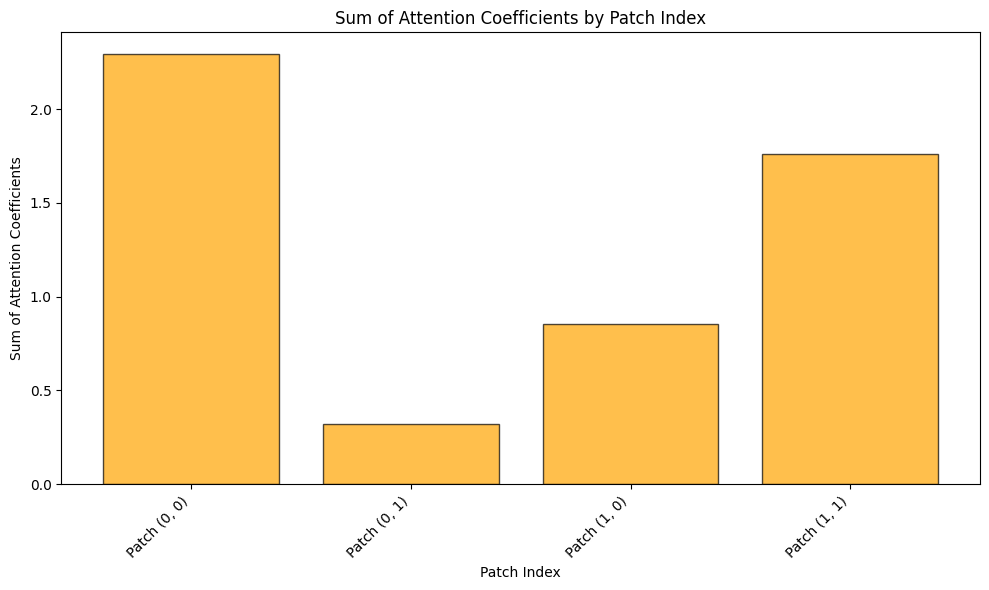

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 4, 16]             272
     SelfAttention-2                [-1, 4, 16]               0
            Linear-3                   [-1, 10]             650
Total params: 922
Trainable params: 922
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [33]:
from torchsummary import summary
summary(model, input_size=(4, 16))  # (sequence_length, embed_size)


In [34]:
# def binary_accuracy(preds, y):
#     """
#     Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
#     """

#     #round predictions to the closest integer
#     rounded_preds = (torch.round(torch.sign(preds-0.5))+1)//2
#     correct = (rounded_preds == y).float() #convert into float for division 
#     acc = correct.sum() / len(correct)
#     return acc

In [35]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

  0%|          | 0/35 [00:00<?, ?it/s]

shape torch.Size([320, 2, 4, 4])


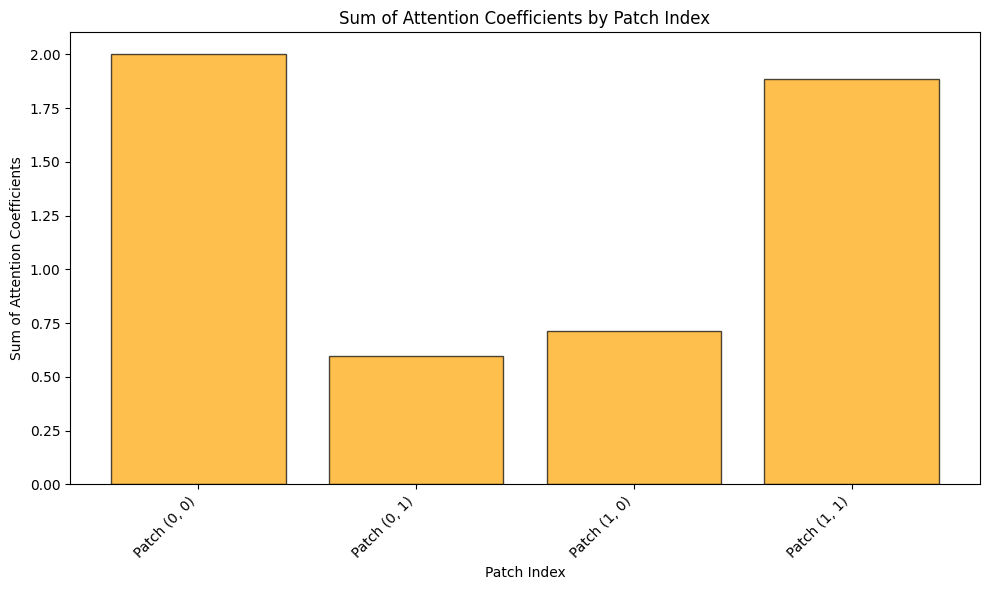

  3%|▎         | 1/35 [00:00<00:04,  6.83it/s]

tensor([1, 9, 9, 9, 1, 1, 9, 1, 9, 1, 9, 1, 9, 9, 1, 1, 9, 1, 9, 1, 9, 1, 1, 1,
        1, 1, 9, 1, 1, 1, 9, 9, 9, 9, 1, 9, 9, 9, 9, 1, 9, 9, 9, 9, 1, 1, 9, 9,
        1, 9, 9, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1, 9, 1, 6, 9, 9, 1, 1, 1, 1, 9,
        1, 1, 0, 9, 9, 1, 1, 1, 1, 1, 8, 1, 1, 1, 9, 1, 1, 1, 9, 9, 1, 9, 9, 9,
        1, 1, 1, 9, 9, 1, 9, 1, 9, 1, 9, 1, 1, 1, 9, 1, 1, 9, 9, 1, 9, 1, 9, 1,
        9, 1, 9, 9, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1, 1, 1, 9, 1, 1, 1, 9, 9, 9,
        1, 9, 1, 9, 9, 1, 9, 9, 9, 1, 1, 9, 1, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 9, 8, 9, 9, 9, 0, 1, 1, 9, 9, 1, 9, 9, 9, 1, 9, 9, 9, 1, 9, 9,
        1, 1, 9, 1, 9, 9, 0, 9, 9, 1, 9, 9, 1, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1,
        9, 9, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 9, 1, 1, 1, 1, 1, 9, 1,
        1, 1, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1, 9, 1, 9, 9, 9, 1, 1, 9, 1, 9, 9, 9,
        1, 9, 1, 1, 9, 9, 9, 1, 1, 9, 9, 9, 9, 9, 9, 1, 1, 1, 9, 9, 9, 9, 1, 1,
        9, 1, 1, 9, 1, 9, 9, 9, 9, 1, 1,

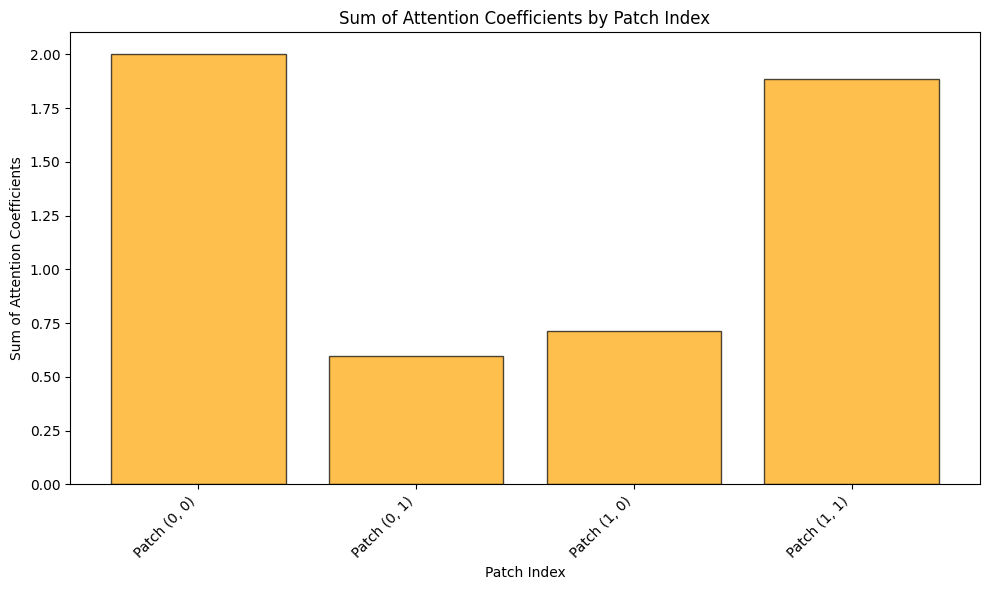

  6%|▌         | 2/35 [00:00<00:04,  6.80it/s]

tensor([1, 9, 6, 9, 1, 1, 9, 1, 9, 1, 9, 1, 9, 9, 1, 1, 9, 1, 9, 1, 9, 1, 1, 1,
        1, 1, 9, 1, 1, 1, 9, 9, 9, 9, 1, 9, 9, 9, 9, 1, 9, 1, 9, 9, 1, 1, 9, 9,
        0, 9, 9, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1, 9, 1, 6, 9, 9, 1, 1, 1, 1, 9,
        1, 1, 0, 9, 9, 1, 1, 1, 1, 1, 8, 1, 1, 1, 9, 1, 1, 1, 9, 9, 1, 9, 9, 9,
        1, 1, 1, 9, 9, 1, 9, 1, 9, 5, 9, 1, 1, 1, 9, 1, 1, 9, 1, 1, 9, 1, 9, 1,
        9, 1, 6, 9, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1, 1, 1, 9, 1, 1, 1, 9, 9, 9,
        1, 9, 1, 9, 9, 1, 9, 9, 9, 1, 1, 9, 6, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 9, 8, 9, 9, 9, 0, 1, 1, 9, 9, 1, 9, 9, 9, 1, 9, 9, 6, 1, 9, 9,
        1, 1, 9, 1, 9, 9, 0, 9, 9, 1, 9, 9, 1, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1,
        9, 9, 1, 1, 1, 1, 9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 9, 1, 1, 1, 1, 1, 9, 1,
        1, 1, 1, 1, 9, 9, 9, 1, 1, 8, 1, 1, 9, 1, 9, 9, 9, 1, 1, 9, 1, 9, 9, 9,
        1, 9, 1, 1, 9, 9, 9, 1, 1, 9, 9, 1, 9, 9, 9, 1, 5, 1, 9, 9, 9, 9, 1, 1,
        9, 1, 1, 9, 1, 9, 9, 9, 5, 1, 1,

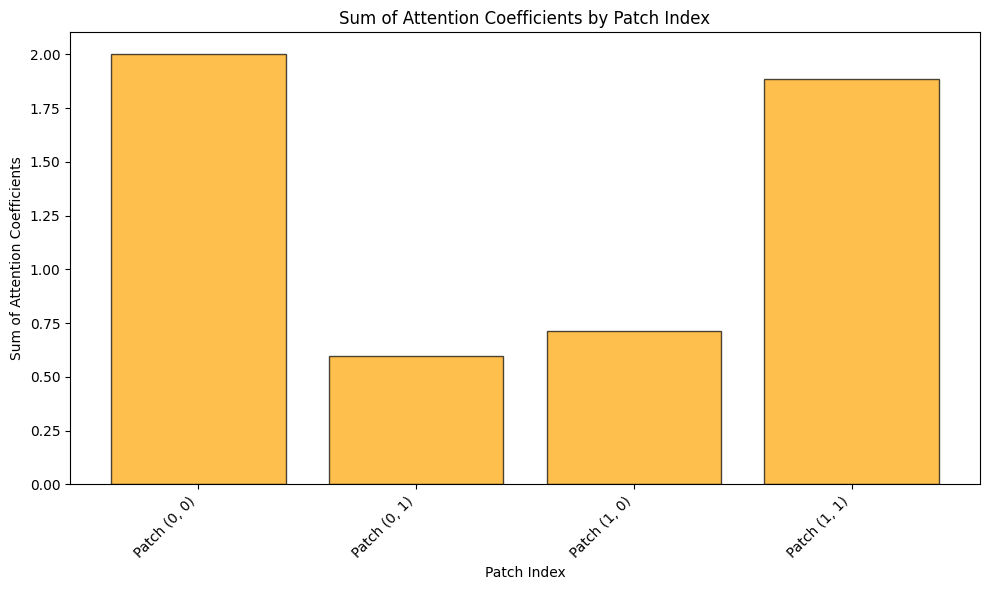

  9%|▊         | 3/35 [00:00<00:04,  6.84it/s]

tensor([0, 9, 6, 9, 5, 1, 9, 1, 9, 1, 9, 1, 9, 9, 1, 1, 9, 1, 9, 5, 9, 1, 1, 1,
        1, 1, 9, 1, 1, 1, 9, 9, 9, 9, 6, 9, 9, 9, 9, 1, 9, 1, 9, 9, 1, 1, 9, 9,
        0, 9, 9, 9, 1, 1, 9, 9, 9, 5, 1, 9, 1, 1, 9, 1, 6, 9, 9, 1, 1, 1, 1, 9,
        1, 1, 0, 9, 6, 1, 5, 1, 1, 1, 8, 1, 1, 1, 9, 1, 1, 1, 9, 9, 1, 9, 9, 9,
        1, 1, 1, 9, 9, 1, 9, 1, 9, 5, 9, 1, 1, 1, 9, 1, 0, 9, 1, 1, 9, 1, 9, 1,
        9, 1, 6, 9, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1, 1, 1, 9, 1, 1, 6, 9, 9, 1,
        1, 9, 1, 9, 1, 1, 9, 9, 9, 1, 1, 9, 6, 9, 9, 9, 1, 9, 1, 1, 1, 1, 1, 1,
        1, 1, 8, 9, 8, 9, 9, 9, 0, 1, 1, 6, 9, 1, 9, 9, 9, 1, 1, 9, 6, 1, 9, 9,
        1, 1, 9, 1, 6, 9, 0, 9, 9, 1, 9, 9, 1, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1,
        9, 9, 1, 1, 1, 1, 1, 9, 9, 1, 9, 9, 9, 1, 9, 9, 9, 1, 1, 1, 1, 1, 9, 1,
        1, 1, 1, 1, 9, 9, 9, 1, 1, 8, 1, 1, 9, 1, 9, 9, 9, 1, 1, 9, 1, 1, 9, 9,
        1, 5, 1, 1, 9, 9, 9, 1, 1, 9, 9, 6, 9, 9, 9, 1, 5, 1, 9, 9, 9, 9, 1, 1,
        9, 5, 1, 9, 5, 9, 9, 9, 5, 1, 1,

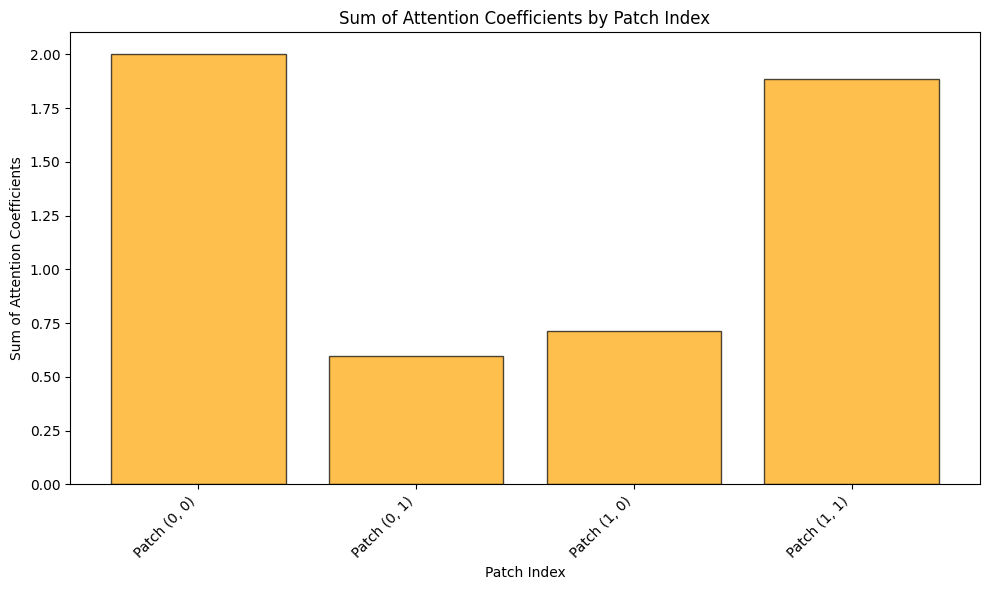

 11%|█▏        | 4/35 [00:00<00:04,  6.58it/s]

tensor([0, 9, 6, 9, 5, 1, 9, 1, 9, 1, 9, 1, 6, 9, 1, 1, 9, 8, 9, 5, 9, 1, 0, 1,
        1, 1, 9, 1, 1, 1, 9, 9, 1, 9, 6, 9, 9, 9, 9, 1, 9, 1, 9, 9, 1, 1, 9, 5,
        0, 9, 8, 9, 1, 6, 9, 9, 9, 5, 1, 9, 1, 1, 9, 1, 6, 9, 9, 1, 1, 1, 1, 9,
        1, 1, 0, 9, 6, 1, 5, 1, 1, 1, 8, 1, 1, 1, 9, 1, 1, 1, 9, 9, 1, 6, 9, 9,
        1, 1, 1, 6, 9, 1, 9, 1, 9, 5, 8, 1, 1, 1, 9, 1, 0, 9, 1, 1, 9, 1, 9, 1,
        9, 1, 6, 9, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1, 1, 1, 9, 1, 1, 6, 9, 9, 1,
        1, 9, 1, 9, 6, 1, 9, 9, 9, 1, 1, 9, 6, 9, 9, 9, 5, 9, 1, 1, 1, 1, 1, 1,
        1, 1, 8, 9, 8, 9, 9, 8, 0, 1, 1, 6, 9, 1, 9, 9, 9, 1, 1, 6, 6, 1, 9, 9,
        1, 1, 9, 1, 6, 5, 0, 9, 9, 1, 9, 9, 1, 9, 1, 1, 9, 9, 9, 1, 1, 9, 1, 1,
        9, 9, 1, 1, 1, 1, 1, 9, 9, 5, 9, 9, 9, 1, 9, 9, 9, 1, 1, 0, 1, 1, 3, 1,
        6, 1, 1, 1, 9, 9, 9, 0, 1, 8, 1, 0, 9, 1, 9, 9, 6, 1, 1, 9, 1, 1, 9, 9,
        1, 5, 1, 1, 9, 9, 9, 1, 1, 9, 9, 6, 9, 9, 9, 1, 5, 1, 9, 9, 9, 9, 1, 3,
        9, 5, 1, 9, 5, 9, 9, 9, 5, 1, 1,

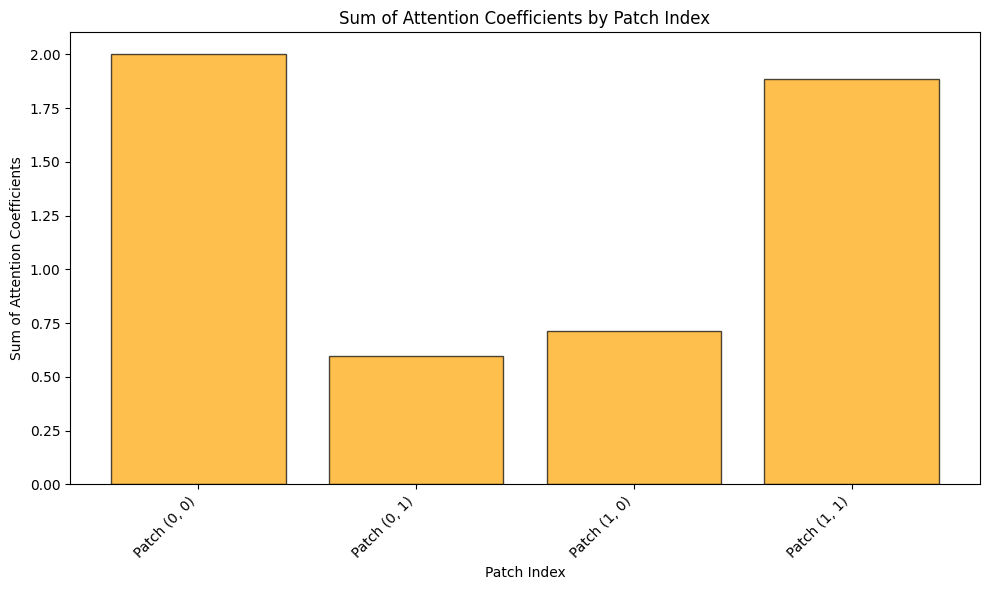

 14%|█▍        | 5/35 [00:00<00:04,  6.64it/s]

tensor([0, 9, 6, 9, 5, 1, 9, 8, 9, 1, 9, 1, 6, 9, 1, 1, 9, 8, 9, 5, 9, 1, 0, 6,
        1, 1, 9, 1, 1, 5, 9, 9, 1, 9, 6, 9, 1, 9, 9, 8, 9, 1, 9, 9, 1, 1, 9, 5,
        0, 9, 8, 9, 8, 6, 9, 9, 9, 5, 1, 9, 1, 1, 9, 1, 6, 9, 9, 1, 1, 1, 1, 9,
        1, 1, 0, 5, 6, 1, 5, 6, 1, 1, 3, 1, 1, 1, 9, 1, 1, 1, 9, 9, 1, 6, 9, 9,
        1, 1, 1, 6, 9, 1, 9, 1, 9, 5, 8, 1, 1, 1, 9, 1, 0, 9, 1, 1, 5, 1, 9, 1,
        6, 1, 6, 9, 9, 1, 1, 9, 9, 9, 8, 1, 9, 0, 1, 1, 1, 9, 8, 6, 6, 9, 1, 5,
        1, 9, 1, 9, 6, 8, 9, 9, 9, 1, 1, 9, 6, 9, 9, 9, 5, 9, 6, 1, 1, 6, 1, 1,
        1, 1, 8, 6, 8, 5, 9, 8, 0, 1, 1, 6, 9, 1, 9, 1, 9, 1, 1, 6, 6, 1, 9, 9,
        1, 1, 9, 0, 6, 5, 0, 9, 9, 1, 9, 9, 1, 9, 1, 1, 9, 9, 9, 1, 1, 5, 1, 1,
        5, 8, 1, 1, 6, 1, 1, 9, 9, 5, 9, 9, 6, 1, 9, 9, 9, 1, 1, 0, 1, 1, 3, 1,
        6, 1, 1, 4, 9, 9, 9, 0, 1, 8, 1, 0, 9, 1, 9, 9, 6, 1, 1, 9, 6, 1, 9, 9,
        1, 5, 1, 1, 9, 9, 9, 1, 1, 6, 9, 6, 9, 9, 9, 1, 5, 1, 9, 9, 9, 9, 1, 3,
        9, 5, 1, 9, 5, 9, 9, 9, 5, 0, 1,

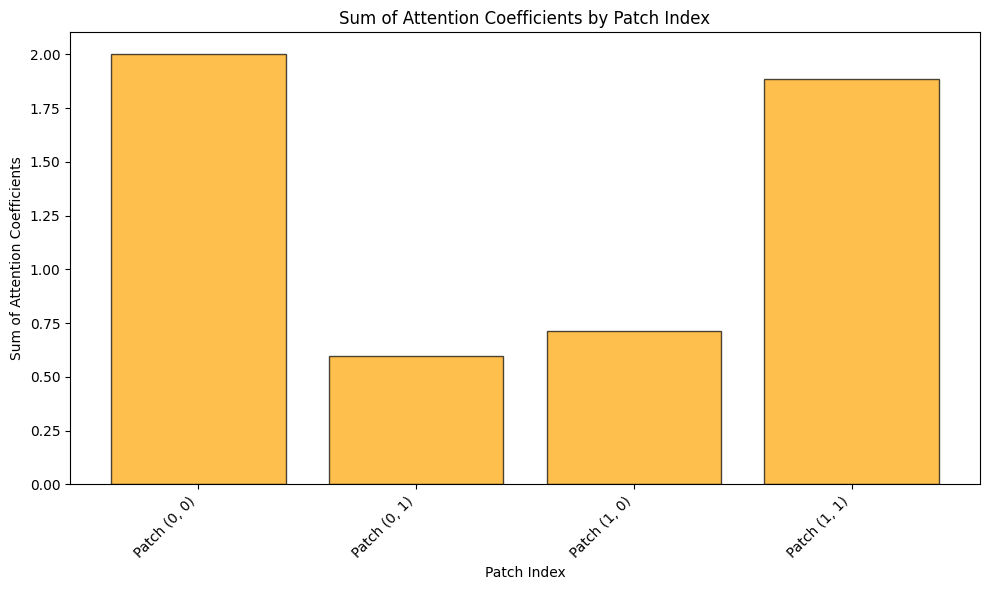

 17%|█▋        | 6/35 [00:00<00:04,  6.60it/s]

tensor([0, 9, 6, 9, 5, 1, 9, 8, 9, 1, 9, 1, 6, 9, 1, 1, 9, 8, 9, 5, 9, 1, 0, 6,
        1, 1, 9, 1, 1, 5, 9, 9, 1, 4, 6, 9, 1, 9, 9, 8, 9, 5, 6, 9, 5, 8, 9, 5,
        0, 9, 8, 9, 8, 6, 9, 9, 1, 5, 1, 9, 1, 1, 9, 1, 6, 9, 9, 1, 1, 1, 1, 9,
        1, 0, 0, 5, 6, 1, 5, 6, 1, 5, 3, 1, 1, 1, 9, 5, 0, 1, 9, 9, 1, 6, 9, 9,
        1, 1, 1, 6, 9, 1, 9, 1, 8, 5, 8, 1, 1, 1, 9, 1, 0, 9, 0, 1, 5, 6, 9, 1,
        6, 1, 6, 9, 9, 1, 1, 8, 9, 9, 8, 1, 9, 0, 1, 1, 1, 4, 8, 6, 6, 9, 1, 5,
        1, 5, 1, 9, 6, 8, 6, 8, 9, 0, 1, 9, 6, 9, 9, 9, 5, 9, 6, 1, 1, 6, 1, 1,
        1, 1, 8, 6, 8, 5, 9, 8, 0, 1, 1, 6, 9, 0, 9, 1, 9, 1, 1, 6, 6, 1, 9, 9,
        1, 1, 9, 0, 6, 5, 0, 9, 9, 1, 9, 9, 1, 9, 1, 1, 9, 9, 9, 1, 1, 5, 1, 1,
        5, 8, 1, 1, 6, 1, 6, 9, 9, 5, 9, 9, 6, 1, 9, 9, 9, 1, 1, 0, 1, 1, 3, 8,
        6, 1, 1, 4, 9, 9, 9, 0, 1, 8, 0, 0, 9, 1, 9, 9, 6, 1, 1, 9, 6, 8, 9, 9,
        1, 5, 1, 1, 9, 9, 9, 1, 1, 6, 8, 6, 9, 9, 9, 1, 5, 8, 9, 9, 8, 9, 1, 3,
        9, 5, 1, 9, 5, 9, 9, 9, 5, 0, 1,

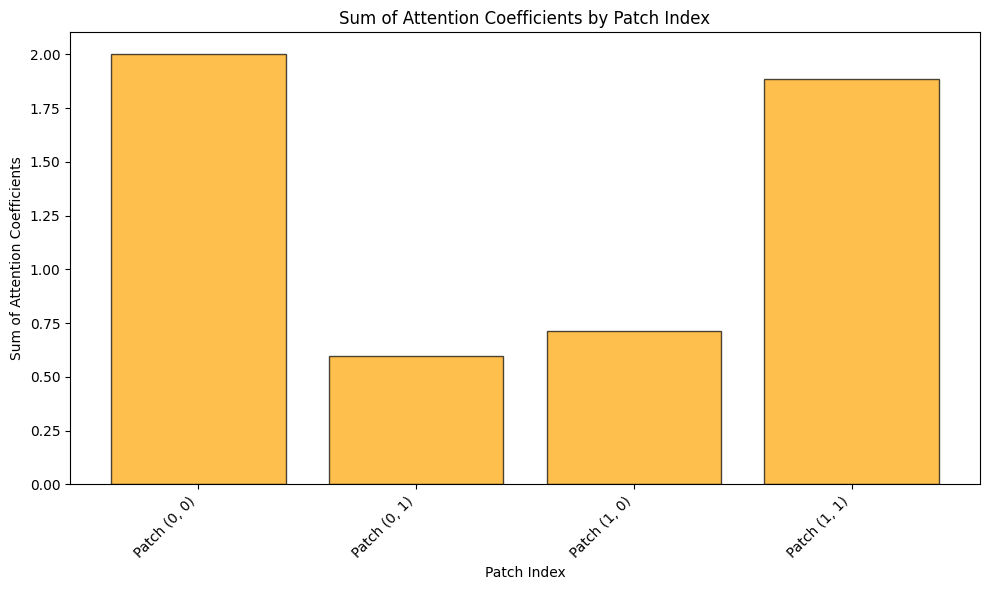

 20%|██        | 7/35 [00:01<00:04,  6.20it/s]

tensor([0, 9, 6, 8, 5, 8, 6, 8, 9, 4, 9, 6, 6, 9, 6, 1, 9, 8, 9, 5, 9, 1, 0, 6,
        1, 1, 9, 1, 1, 5, 9, 9, 5, 4, 6, 1, 1, 9, 9, 8, 9, 5, 6, 6, 5, 8, 8, 5,
        0, 9, 8, 9, 8, 6, 9, 9, 1, 5, 1, 9, 1, 0, 9, 1, 6, 6, 9, 1, 3, 1, 1, 4,
        1, 0, 0, 5, 6, 1, 5, 6, 1, 5, 3, 1, 1, 1, 5, 5, 0, 1, 8, 8, 1, 6, 9, 9,
        1, 1, 1, 6, 9, 1, 9, 1, 8, 5, 8, 1, 1, 1, 9, 1, 0, 9, 0, 8, 5, 6, 9, 1,
        6, 1, 6, 9, 9, 1, 1, 8, 9, 8, 5, 1, 9, 0, 1, 1, 1, 4, 8, 6, 6, 9, 1, 5,
        5, 5, 1, 9, 6, 8, 6, 8, 6, 0, 1, 9, 6, 9, 9, 9, 5, 8, 6, 1, 1, 6, 1, 1,
        1, 1, 8, 6, 8, 5, 9, 8, 0, 1, 1, 6, 9, 0, 6, 1, 9, 1, 1, 6, 6, 1, 9, 9,
        1, 1, 9, 0, 6, 5, 0, 8, 9, 1, 4, 9, 1, 9, 1, 8, 9, 9, 9, 0, 1, 5, 1, 3,
        5, 8, 1, 1, 6, 1, 6, 4, 9, 5, 8, 9, 6, 1, 9, 9, 8, 1, 6, 0, 1, 8, 3, 8,
        6, 1, 1, 4, 9, 9, 9, 0, 1, 8, 0, 0, 0, 1, 9, 9, 6, 1, 1, 9, 6, 8, 9, 5,
        5, 5, 0, 1, 5, 9, 9, 0, 1, 6, 8, 6, 9, 5, 9, 1, 5, 8, 9, 9, 8, 9, 1, 3,
        9, 5, 6, 9, 5, 9, 9, 9, 5, 0, 1,

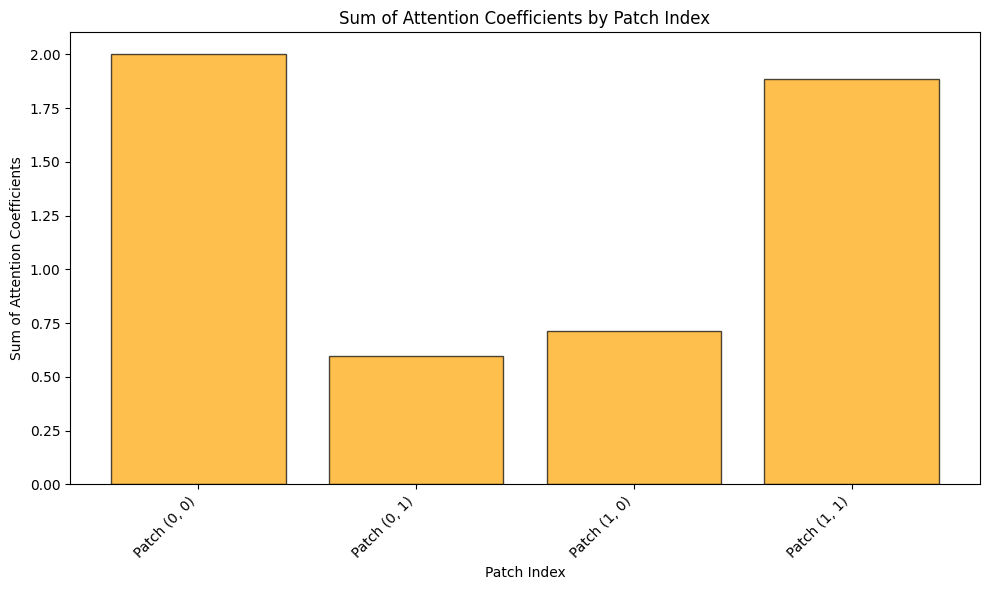

 23%|██▎       | 8/35 [00:01<00:04,  6.38it/s]

tensor([0, 9, 6, 8, 5, 8, 6, 8, 9, 4, 6, 6, 6, 9, 0, 1, 9, 8, 9, 5, 6, 6, 0, 6,
        6, 5, 9, 1, 6, 5, 9, 9, 5, 4, 6, 1, 1, 9, 9, 8, 9, 5, 6, 6, 5, 8, 8, 5,
        0, 9, 8, 9, 8, 6, 9, 9, 1, 5, 1, 9, 1, 0, 9, 5, 6, 6, 9, 1, 3, 4, 1, 4,
        8, 0, 0, 5, 6, 1, 5, 6, 6, 5, 3, 1, 1, 1, 5, 5, 0, 0, 8, 8, 8, 6, 9, 4,
        1, 4, 1, 6, 9, 3, 9, 1, 8, 5, 8, 1, 1, 1, 8, 1, 0, 9, 0, 8, 5, 6, 9, 6,
        6, 1, 6, 9, 9, 1, 1, 8, 9, 8, 5, 5, 9, 4, 0, 0, 1, 4, 8, 4, 6, 9, 1, 5,
        5, 5, 3, 9, 6, 8, 6, 8, 6, 0, 1, 9, 6, 9, 9, 1, 5, 8, 6, 1, 1, 6, 1, 1,
        1, 1, 8, 6, 8, 5, 9, 8, 0, 1, 1, 6, 5, 0, 6, 1, 9, 1, 1, 6, 6, 1, 9, 9,
        1, 6, 9, 0, 6, 5, 0, 8, 9, 1, 4, 9, 1, 9, 1, 8, 9, 9, 9, 0, 8, 5, 1, 3,
        5, 8, 1, 8, 6, 0, 6, 4, 4, 5, 8, 9, 6, 1, 9, 9, 8, 1, 6, 0, 1, 8, 3, 8,
        6, 1, 1, 4, 9, 9, 9, 0, 1, 8, 0, 0, 0, 1, 9, 8, 6, 1, 1, 9, 6, 8, 9, 5,
        5, 5, 0, 1, 5, 9, 6, 0, 1, 6, 8, 6, 9, 8, 9, 6, 5, 8, 9, 9, 8, 9, 1, 3,
        9, 5, 6, 9, 5, 9, 3, 9, 5, 0, 1,

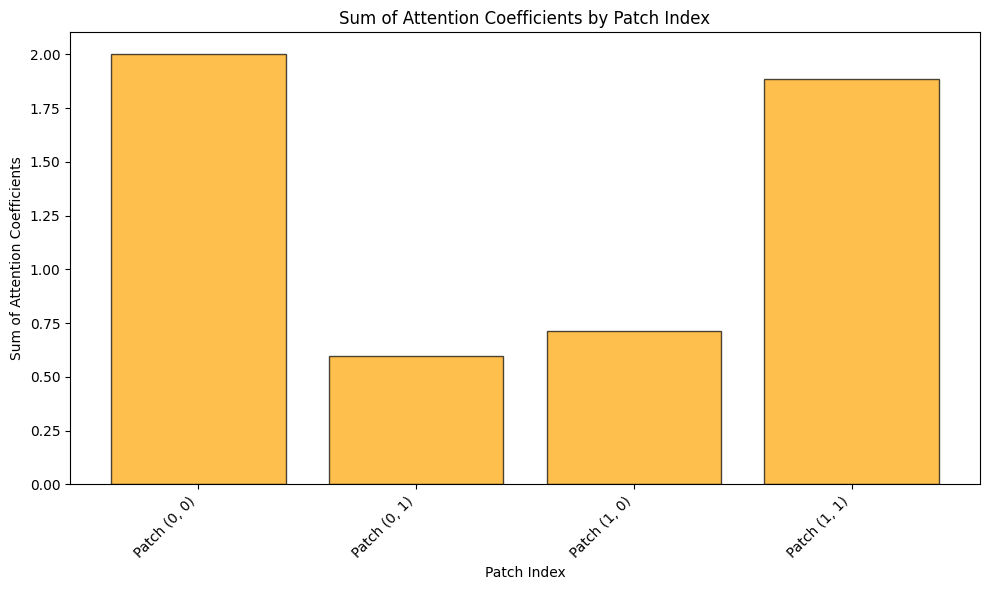

 26%|██▌       | 9/35 [00:01<00:04,  6.48it/s]

tensor([0, 9, 6, 4, 5, 8, 8, 8, 6, 4, 6, 6, 6, 9, 0, 6, 9, 8, 9, 5, 8, 6, 0, 6,
        6, 5, 9, 1, 6, 5, 9, 9, 5, 4, 6, 1, 1, 8, 9, 8, 5, 5, 6, 6, 5, 8, 8, 5,
        0, 9, 8, 9, 8, 5, 9, 9, 1, 5, 1, 9, 1, 0, 9, 5, 6, 6, 9, 1, 3, 4, 0, 4,
        8, 0, 0, 5, 6, 1, 5, 6, 6, 5, 3, 1, 0, 1, 5, 5, 0, 0, 8, 8, 8, 6, 5, 4,
        1, 4, 1, 6, 9, 3, 9, 4, 8, 5, 8, 1, 1, 1, 8, 3, 0, 9, 0, 8, 5, 6, 9, 6,
        6, 1, 4, 9, 9, 6, 1, 8, 9, 8, 5, 5, 9, 4, 0, 0, 1, 4, 8, 4, 6, 4, 8, 5,
        5, 5, 3, 9, 6, 8, 6, 8, 6, 0, 1, 9, 6, 9, 9, 5, 5, 8, 6, 0, 0, 6, 1, 1,
        1, 1, 8, 6, 8, 5, 9, 8, 0, 0, 1, 6, 5, 0, 6, 1, 9, 1, 1, 6, 6, 1, 9, 9,
        8, 6, 4, 0, 6, 5, 0, 8, 9, 1, 4, 5, 1, 8, 1, 8, 9, 4, 9, 0, 8, 5, 1, 3,
        5, 8, 1, 8, 6, 0, 6, 4, 4, 5, 8, 6, 6, 0, 9, 8, 8, 1, 6, 0, 1, 8, 3, 8,
        6, 1, 1, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 9, 8, 6, 1, 1, 9, 6, 3, 9, 5,
        5, 5, 0, 1, 5, 9, 6, 0, 1, 6, 8, 6, 9, 8, 9, 6, 5, 8, 9, 9, 8, 9, 0, 3,
        0, 5, 6, 9, 5, 9, 3, 9, 5, 0, 1,

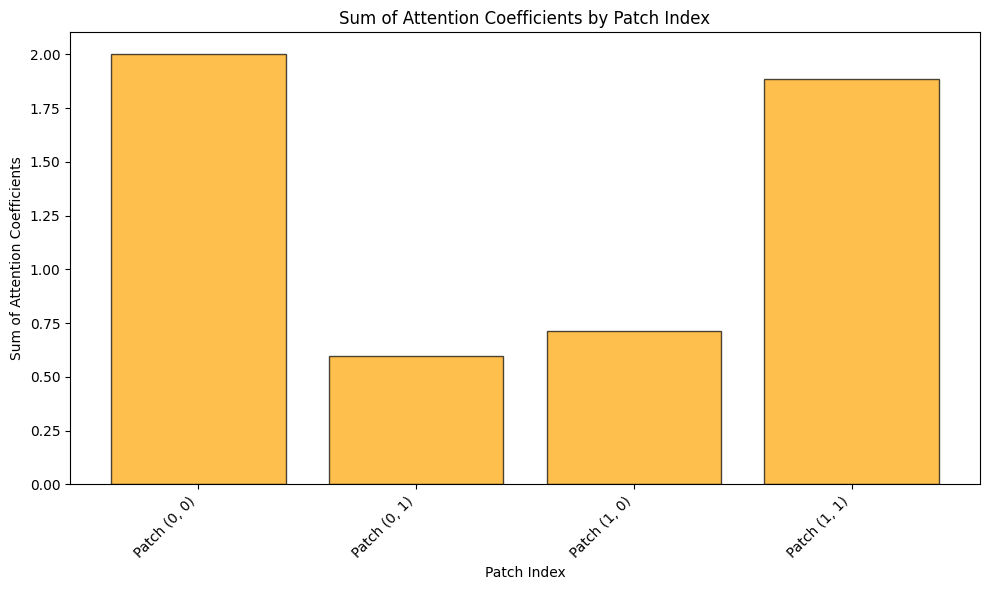

 29%|██▊       | 10/35 [00:01<00:03,  6.56it/s]

tensor([0, 8, 6, 4, 5, 3, 8, 8, 6, 4, 6, 6, 6, 9, 0, 6, 9, 8, 9, 5, 8, 6, 0, 6,
        6, 5, 9, 1, 6, 5, 9, 2, 5, 4, 6, 1, 1, 8, 9, 8, 5, 5, 6, 6, 5, 8, 8, 5,
        0, 8, 8, 8, 3, 5, 9, 9, 1, 5, 8, 5, 1, 0, 3, 5, 6, 6, 9, 5, 3, 4, 0, 4,
        8, 0, 0, 5, 6, 1, 5, 6, 2, 5, 3, 1, 0, 1, 5, 5, 0, 0, 8, 8, 8, 6, 5, 4,
        6, 4, 5, 6, 9, 3, 9, 4, 8, 5, 8, 1, 1, 8, 8, 3, 0, 9, 0, 8, 5, 6, 4, 6,
        6, 4, 4, 8, 9, 6, 1, 8, 9, 8, 5, 5, 9, 4, 0, 4, 1, 4, 8, 4, 6, 4, 8, 5,
        5, 5, 3, 9, 6, 8, 6, 8, 6, 0, 1, 9, 6, 9, 9, 5, 5, 2, 6, 0, 0, 6, 1, 5,
        1, 1, 8, 6, 8, 5, 9, 8, 0, 0, 4, 4, 5, 0, 6, 1, 8, 4, 6, 6, 6, 6, 6, 9,
        8, 6, 4, 0, 6, 5, 0, 8, 9, 1, 4, 5, 1, 8, 1, 4, 6, 4, 8, 0, 8, 5, 1, 3,
        5, 8, 1, 8, 6, 0, 6, 4, 4, 5, 8, 6, 6, 0, 9, 8, 8, 1, 6, 0, 1, 8, 3, 5,
        6, 1, 0, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 9, 8, 4, 1, 1, 1, 6, 3, 9, 5,
        0, 5, 0, 5, 5, 9, 6, 0, 1, 6, 8, 6, 9, 8, 4, 6, 5, 8, 9, 9, 8, 9, 0, 3,
        0, 5, 6, 6, 5, 9, 3, 9, 5, 0, 1,

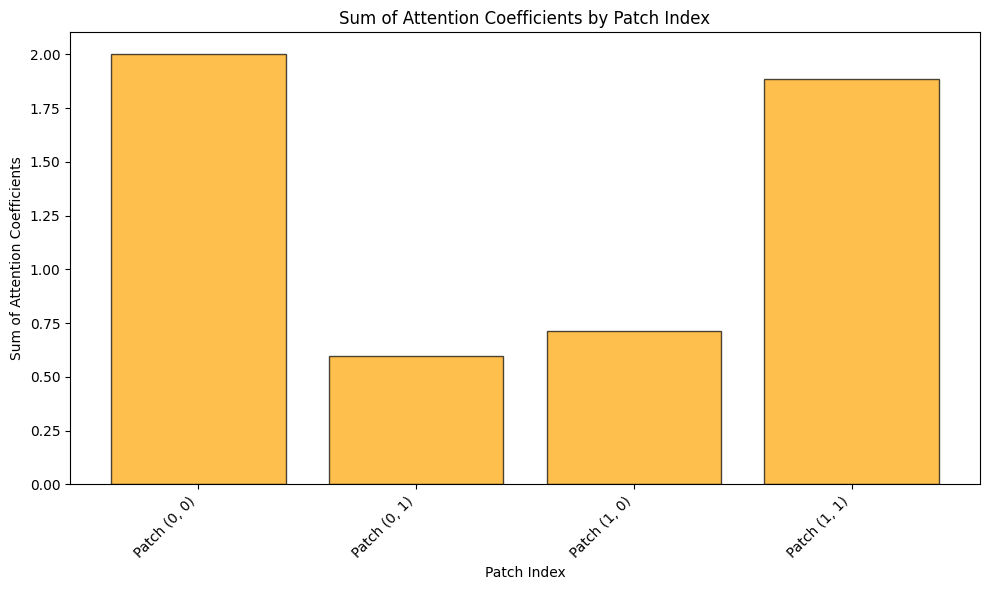

 31%|███▏      | 11/35 [00:01<00:03,  6.59it/s]

tensor([0, 8, 6, 4, 5, 3, 8, 8, 6, 4, 6, 6, 6, 9, 0, 6, 3, 8, 9, 5, 8, 3, 0, 6,
        3, 5, 9, 1, 6, 5, 9, 2, 5, 4, 6, 1, 8, 8, 9, 0, 5, 5, 6, 6, 5, 8, 8, 5,
        0, 8, 8, 8, 3, 5, 9, 9, 8, 5, 8, 5, 4, 0, 3, 5, 6, 6, 9, 5, 3, 4, 0, 4,
        8, 0, 0, 5, 6, 1, 5, 6, 2, 5, 3, 1, 4, 1, 5, 5, 0, 0, 8, 8, 8, 6, 5, 4,
        6, 4, 5, 6, 9, 3, 9, 4, 8, 5, 8, 1, 1, 4, 8, 3, 0, 9, 0, 8, 5, 6, 4, 6,
        6, 4, 4, 8, 1, 6, 5, 8, 9, 8, 5, 5, 9, 4, 0, 4, 6, 4, 8, 4, 6, 4, 8, 5,
        5, 5, 3, 9, 6, 8, 6, 8, 6, 0, 1, 9, 6, 9, 9, 5, 5, 2, 5, 0, 4, 6, 1, 5,
        0, 1, 8, 6, 8, 5, 8, 8, 0, 0, 4, 4, 5, 0, 6, 1, 8, 4, 8, 6, 6, 6, 6, 9,
        4, 6, 4, 0, 6, 5, 0, 8, 1, 1, 4, 5, 1, 8, 1, 4, 6, 4, 8, 0, 8, 5, 1, 3,
        5, 8, 1, 8, 6, 0, 6, 4, 4, 5, 8, 6, 6, 0, 9, 8, 8, 1, 6, 0, 1, 4, 3, 5,
        6, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 9, 8, 4, 1, 1, 1, 6, 3, 9, 5,
        0, 5, 0, 5, 5, 9, 2, 0, 1, 6, 8, 6, 9, 4, 4, 6, 5, 0, 9, 9, 8, 8, 0, 3,
        0, 5, 0, 8, 5, 9, 3, 9, 5, 0, 1,

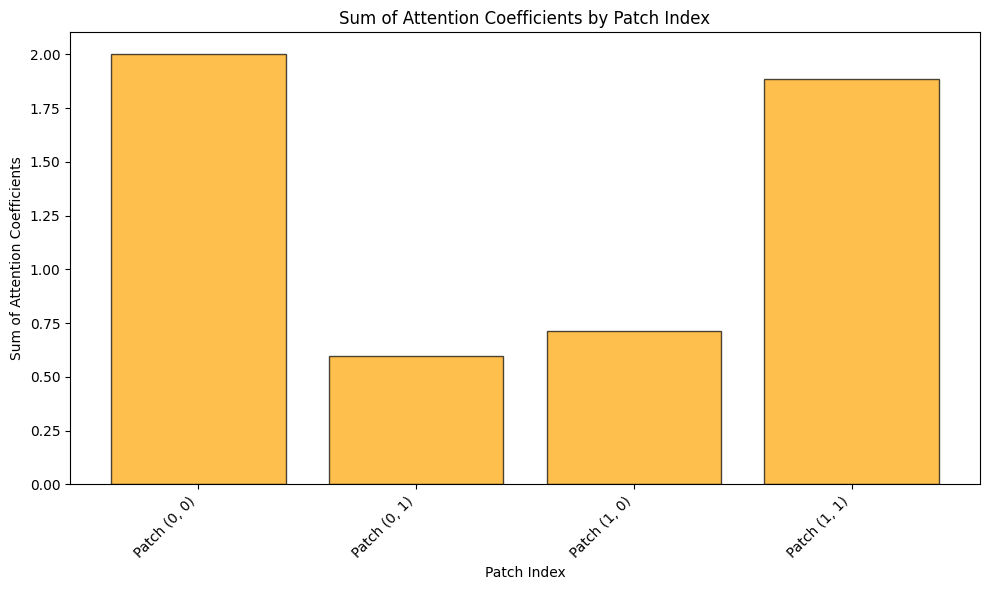

 34%|███▍      | 12/35 [00:01<00:03,  6.69it/s]

tensor([0, 8, 6, 4, 5, 3, 8, 8, 6, 4, 6, 6, 6, 9, 0, 6, 3, 8, 9, 5, 8, 3, 0, 6,
        3, 5, 9, 1, 6, 5, 9, 2, 5, 4, 6, 1, 8, 8, 4, 0, 5, 5, 4, 6, 5, 8, 8, 5,
        0, 8, 5, 3, 3, 5, 4, 9, 8, 5, 8, 5, 4, 0, 3, 5, 6, 6, 4, 5, 3, 4, 0, 4,
        8, 0, 0, 5, 2, 8, 5, 6, 2, 5, 3, 5, 4, 1, 5, 5, 0, 0, 8, 4, 8, 4, 5, 4,
        6, 4, 5, 6, 9, 3, 5, 4, 8, 5, 5, 1, 6, 4, 8, 3, 0, 9, 0, 8, 5, 6, 4, 6,
        6, 4, 4, 8, 1, 6, 3, 8, 9, 8, 5, 5, 9, 4, 0, 4, 6, 4, 4, 4, 6, 4, 8, 5,
        5, 5, 3, 9, 6, 8, 4, 8, 6, 0, 1, 9, 6, 9, 2, 5, 5, 2, 5, 0, 4, 6, 8, 5,
        0, 0, 8, 6, 8, 5, 8, 8, 0, 0, 4, 4, 4, 0, 6, 1, 4, 4, 8, 6, 6, 6, 6, 9,
        4, 6, 4, 0, 6, 5, 0, 8, 1, 1, 4, 5, 1, 8, 6, 4, 6, 4, 8, 0, 8, 5, 1, 3,
        5, 8, 1, 8, 6, 0, 6, 4, 4, 5, 8, 6, 6, 0, 6, 8, 8, 1, 6, 0, 1, 4, 3, 5,
        6, 1, 3, 4, 8, 9, 9, 0, 4, 8, 0, 0, 0, 1, 9, 8, 4, 1, 1, 1, 6, 3, 9, 5,
        0, 5, 0, 5, 5, 9, 2, 0, 1, 6, 8, 6, 9, 4, 4, 6, 5, 0, 8, 9, 8, 8, 0, 3,
        0, 5, 0, 8, 5, 8, 3, 9, 5, 0, 6,

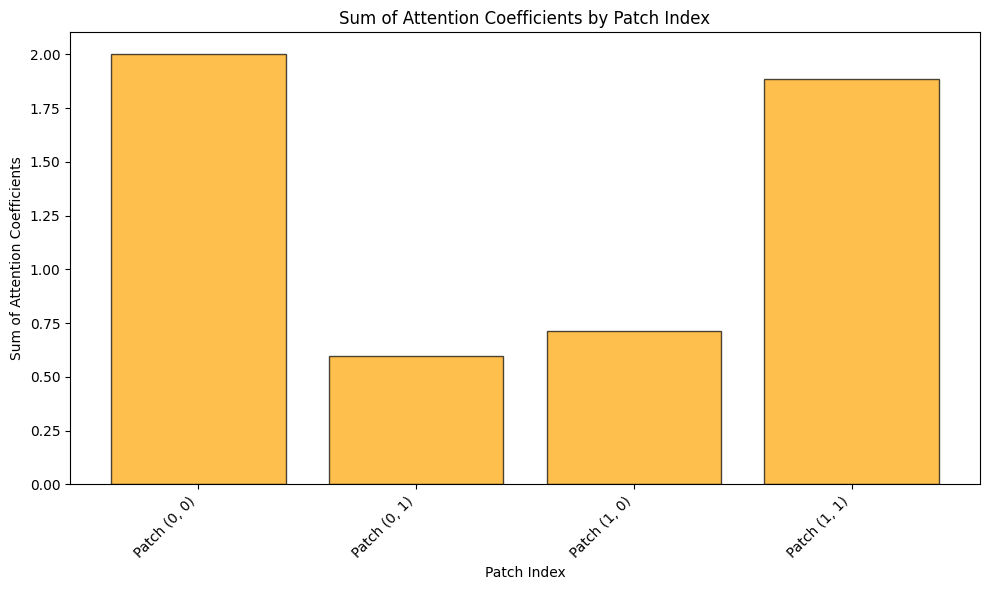

 37%|███▋      | 13/35 [00:01<00:03,  6.77it/s]

tensor([0, 8, 2, 4, 5, 3, 8, 8, 6, 4, 6, 6, 2, 8, 0, 6, 3, 8, 9, 5, 4, 3, 0, 6,
        3, 5, 4, 1, 6, 5, 9, 2, 5, 4, 6, 1, 8, 8, 4, 0, 3, 5, 4, 6, 5, 8, 8, 5,
        0, 8, 5, 3, 3, 5, 4, 9, 4, 5, 8, 5, 4, 0, 3, 2, 6, 6, 4, 5, 3, 3, 0, 4,
        8, 0, 0, 5, 2, 8, 5, 6, 2, 5, 3, 5, 4, 1, 5, 5, 0, 3, 3, 4, 8, 4, 5, 4,
        6, 4, 5, 6, 2, 3, 5, 4, 8, 5, 5, 4, 6, 4, 8, 3, 0, 9, 0, 8, 5, 2, 4, 6,
        6, 4, 4, 8, 1, 2, 3, 8, 4, 8, 5, 5, 9, 4, 0, 4, 6, 4, 3, 4, 6, 4, 8, 3,
        5, 4, 3, 9, 6, 8, 4, 2, 6, 0, 1, 9, 6, 2, 2, 5, 5, 2, 5, 0, 4, 6, 8, 5,
        0, 0, 8, 6, 8, 5, 8, 3, 0, 0, 4, 4, 4, 0, 6, 1, 4, 4, 8, 6, 6, 6, 6, 9,
        4, 6, 4, 0, 6, 5, 0, 8, 6, 1, 4, 5, 1, 8, 6, 4, 6, 4, 3, 0, 8, 5, 1, 3,
        5, 8, 1, 8, 4, 0, 6, 4, 4, 5, 8, 6, 6, 0, 6, 4, 8, 1, 6, 0, 7, 4, 3, 5,
        6, 1, 3, 4, 8, 9, 9, 0, 4, 8, 0, 0, 0, 1, 6, 8, 4, 1, 1, 8, 6, 3, 9, 5,
        0, 5, 0, 5, 5, 9, 2, 0, 1, 6, 8, 6, 9, 4, 4, 6, 5, 0, 3, 9, 8, 8, 7, 3,
        0, 5, 0, 4, 5, 8, 3, 9, 5, 0, 3,

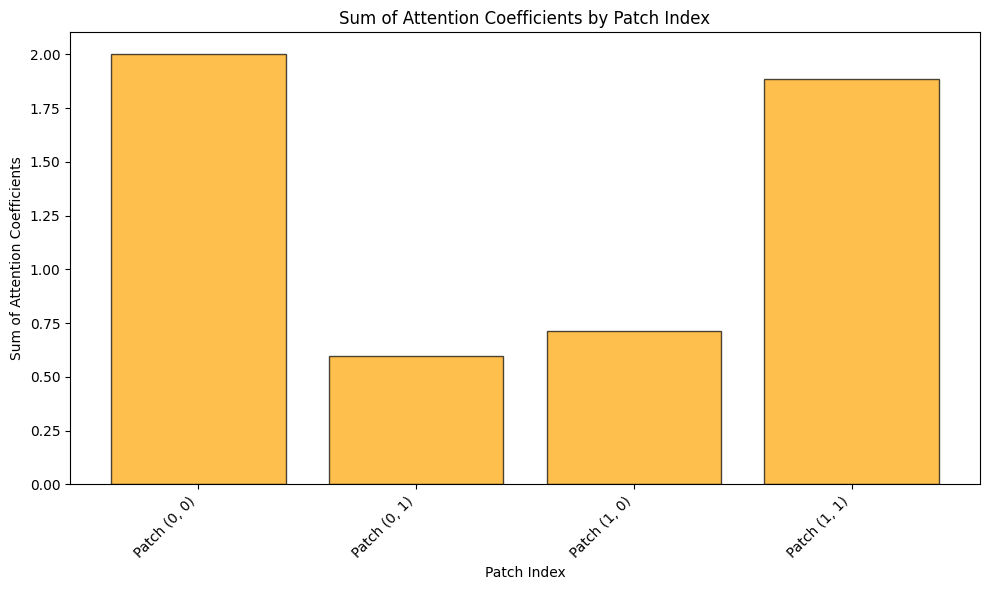

 40%|████      | 14/35 [00:02<00:03,  6.64it/s]

tensor([0, 8, 2, 4, 5, 3, 8, 8, 6, 4, 6, 6, 2, 2, 0, 6, 3, 8, 9, 5, 4, 3, 0, 6,
        3, 5, 4, 1, 6, 5, 9, 2, 5, 4, 6, 1, 8, 8, 4, 3, 3, 5, 4, 6, 7, 8, 8, 5,
        0, 8, 5, 3, 3, 5, 4, 9, 4, 5, 8, 5, 3, 0, 3, 2, 6, 6, 4, 5, 3, 3, 0, 4,
        8, 0, 0, 5, 2, 8, 5, 6, 2, 5, 3, 3, 4, 0, 4, 5, 0, 3, 3, 4, 4, 4, 5, 4,
        6, 4, 5, 6, 2, 3, 5, 4, 8, 5, 5, 4, 3, 4, 2, 3, 0, 9, 0, 8, 5, 2, 2, 6,
        2, 4, 4, 8, 1, 2, 3, 8, 4, 8, 5, 5, 9, 4, 3, 4, 6, 4, 3, 4, 6, 4, 8, 3,
        4, 4, 3, 9, 6, 8, 4, 2, 6, 0, 4, 4, 6, 2, 2, 5, 5, 2, 5, 0, 4, 6, 8, 6,
        0, 0, 8, 6, 8, 5, 4, 3, 0, 0, 4, 4, 4, 0, 6, 1, 4, 4, 8, 6, 6, 6, 6, 9,
        4, 6, 4, 0, 6, 5, 0, 8, 6, 1, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 8, 5, 0, 3,
        5, 8, 1, 8, 4, 0, 2, 4, 4, 5, 8, 2, 6, 0, 6, 4, 2, 1, 6, 0, 7, 4, 3, 5,
        6, 1, 3, 4, 8, 9, 9, 0, 4, 8, 0, 0, 0, 1, 6, 8, 4, 7, 1, 8, 6, 3, 4, 5,
        0, 5, 0, 5, 5, 2, 2, 0, 1, 6, 8, 6, 2, 4, 4, 6, 5, 3, 3, 9, 8, 8, 7, 3,
        0, 5, 0, 4, 5, 8, 3, 9, 5, 0, 3,

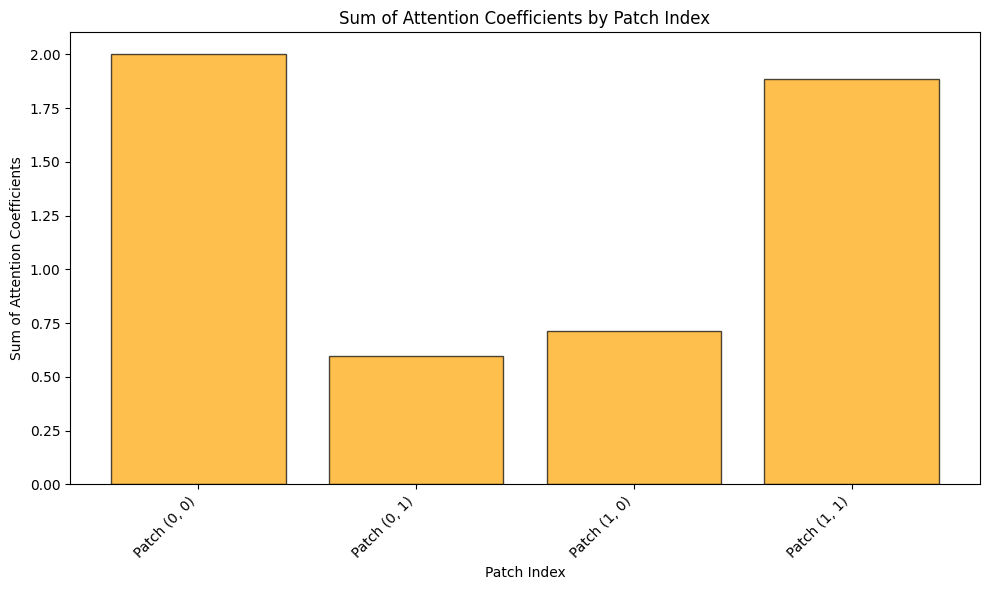

 43%|████▎     | 15/35 [00:02<00:02,  6.74it/s]

tensor([0, 8, 2, 4, 5, 3, 2, 4, 6, 4, 6, 6, 2, 2, 0, 6, 3, 3, 1, 5, 4, 3, 0, 6,
        3, 5, 4, 1, 6, 5, 9, 2, 5, 4, 6, 1, 8, 4, 4, 3, 3, 5, 4, 6, 7, 5, 8, 5,
        0, 3, 5, 3, 3, 5, 4, 9, 4, 5, 7, 5, 3, 0, 3, 2, 6, 2, 4, 5, 3, 3, 0, 4,
        8, 0, 0, 5, 2, 3, 7, 6, 2, 5, 3, 3, 4, 0, 4, 5, 0, 3, 3, 4, 4, 4, 5, 4,
        6, 4, 5, 6, 2, 3, 5, 4, 8, 5, 5, 4, 3, 4, 2, 3, 0, 3, 0, 8, 5, 2, 2, 0,
        2, 4, 4, 8, 1, 2, 3, 8, 4, 8, 5, 5, 9, 4, 3, 4, 0, 4, 3, 4, 6, 4, 8, 3,
        4, 4, 3, 9, 6, 8, 4, 2, 6, 0, 4, 4, 6, 2, 2, 5, 5, 2, 5, 0, 4, 6, 8, 6,
        0, 0, 8, 6, 8, 5, 4, 3, 0, 0, 4, 4, 4, 0, 6, 1, 4, 4, 8, 6, 6, 6, 6, 2,
        4, 6, 4, 0, 6, 5, 0, 3, 6, 1, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 8, 5, 0, 3,
        4, 8, 2, 8, 4, 0, 2, 4, 4, 5, 8, 2, 6, 0, 2, 4, 2, 1, 6, 0, 7, 4, 3, 5,
        6, 3, 3, 4, 8, 9, 9, 0, 4, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 8, 6, 3, 4, 5,
        0, 5, 0, 3, 5, 2, 2, 0, 3, 4, 8, 6, 2, 4, 4, 6, 7, 3, 3, 9, 8, 2, 7, 3,
        2, 5, 0, 4, 5, 8, 3, 9, 5, 0, 3,

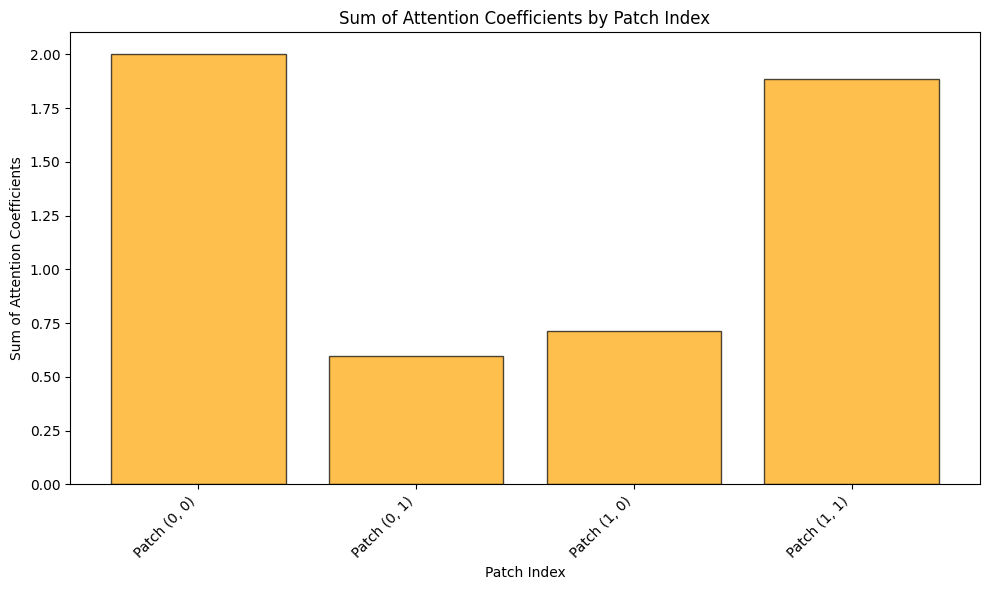

 46%|████▌     | 16/35 [00:02<00:02,  6.81it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 4, 6, 4, 6, 6, 2, 2, 0, 6, 3, 3, 1, 5, 2, 3, 0, 6,
        3, 5, 4, 1, 7, 5, 9, 2, 5, 4, 6, 1, 2, 4, 4, 3, 3, 5, 2, 2, 7, 5, 8, 8,
        0, 3, 5, 3, 3, 6, 4, 9, 4, 5, 7, 5, 3, 0, 3, 2, 6, 2, 4, 5, 3, 3, 0, 4,
        8, 0, 0, 5, 2, 3, 7, 6, 2, 5, 3, 3, 4, 0, 4, 5, 0, 3, 3, 4, 4, 4, 5, 4,
        6, 4, 7, 6, 2, 3, 5, 4, 3, 5, 5, 0, 3, 4, 2, 3, 0, 3, 0, 8, 5, 2, 2, 0,
        2, 4, 4, 3, 1, 2, 3, 8, 4, 8, 5, 5, 9, 4, 3, 0, 0, 4, 3, 4, 6, 4, 8, 3,
        4, 4, 3, 9, 6, 8, 4, 2, 6, 0, 4, 4, 6, 2, 2, 2, 5, 2, 5, 0, 4, 6, 4, 6,
        0, 0, 8, 4, 3, 5, 4, 3, 0, 0, 4, 4, 4, 0, 6, 1, 4, 4, 8, 6, 6, 6, 4, 2,
        3, 6, 4, 0, 2, 4, 0, 3, 6, 1, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 8, 2, 0, 3,
        4, 8, 2, 8, 4, 0, 2, 4, 4, 5, 3, 2, 6, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        6, 3, 3, 4, 8, 9, 9, 0, 4, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 5, 0, 3, 5, 2, 2, 0, 3, 4, 8, 6, 2, 4, 4, 6, 7, 3, 3, 9, 8, 2, 7, 3,
        2, 5, 0, 4, 5, 8, 3, 9, 5, 0, 3,

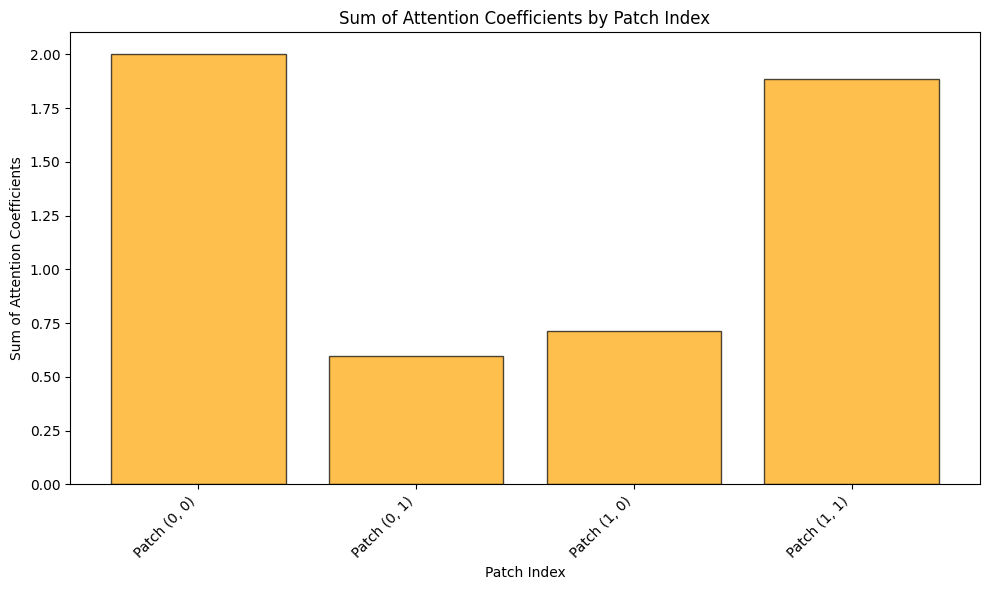

 49%|████▊     | 17/35 [00:02<00:02,  6.84it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 4, 2, 4, 2, 6, 2, 2, 0, 6, 3, 3, 1, 5, 2, 3, 0, 6,
        3, 5, 4, 1, 7, 5, 2, 2, 5, 4, 6, 1, 2, 4, 4, 3, 3, 5, 2, 2, 7, 4, 4, 8,
        0, 3, 5, 3, 3, 6, 4, 9, 4, 5, 7, 7, 3, 0, 3, 2, 6, 2, 4, 5, 3, 3, 0, 4,
        7, 0, 0, 5, 2, 3, 7, 6, 2, 5, 3, 3, 4, 0, 4, 5, 0, 3, 3, 4, 4, 4, 5, 4,
        6, 4, 7, 6, 2, 3, 0, 4, 3, 5, 5, 0, 3, 4, 2, 3, 0, 3, 0, 8, 5, 2, 2, 0,
        2, 4, 4, 3, 1, 2, 3, 8, 4, 8, 5, 4, 2, 4, 3, 0, 0, 4, 7, 4, 6, 4, 8, 3,
        4, 4, 3, 9, 6, 8, 4, 2, 6, 0, 3, 0, 6, 2, 2, 2, 5, 2, 5, 0, 4, 6, 4, 6,
        0, 0, 4, 4, 3, 5, 7, 3, 0, 0, 3, 4, 4, 0, 6, 1, 4, 4, 8, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 4, 0, 3, 2, 0, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 3, 2, 0, 3,
        4, 8, 2, 3, 4, 0, 2, 4, 4, 5, 3, 2, 6, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        4, 3, 3, 4, 8, 9, 9, 0, 4, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 5, 0, 3, 5, 2, 2, 0, 3, 4, 8, 6, 2, 4, 4, 2, 7, 3, 3, 9, 8, 2, 7, 3,
        2, 5, 0, 4, 5, 8, 3, 9, 5, 0, 3,

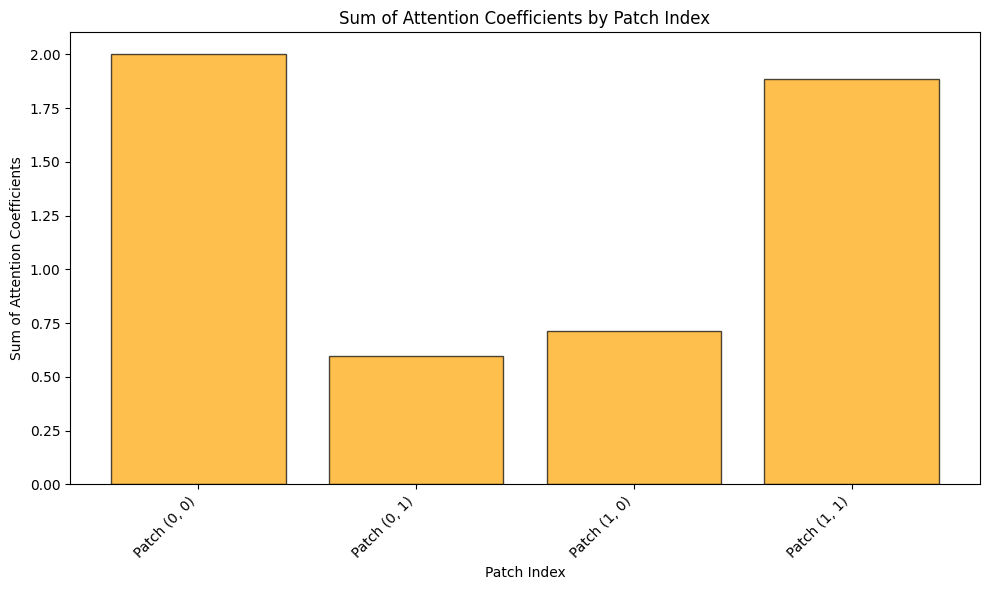

 51%|█████▏    | 18/35 [00:02<00:02,  6.88it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 4, 2, 4, 2, 6, 2, 2, 0, 6, 3, 3, 1, 5, 2, 3, 0, 6,
        3, 5, 4, 1, 7, 5, 2, 2, 5, 4, 6, 1, 2, 4, 4, 3, 3, 5, 2, 2, 7, 4, 4, 8,
        0, 3, 5, 3, 3, 6, 4, 9, 4, 5, 7, 7, 3, 0, 2, 2, 6, 2, 4, 5, 3, 3, 0, 4,
        7, 0, 0, 5, 2, 3, 7, 6, 2, 5, 3, 3, 4, 0, 4, 5, 0, 3, 3, 4, 4, 4, 2, 4,
        6, 4, 7, 6, 2, 3, 0, 4, 3, 5, 5, 0, 3, 4, 2, 3, 0, 3, 2, 8, 5, 2, 2, 0,
        2, 4, 4, 3, 1, 2, 3, 8, 4, 8, 5, 3, 2, 4, 3, 0, 0, 4, 7, 4, 6, 4, 8, 3,
        4, 4, 3, 9, 6, 8, 4, 2, 2, 0, 3, 0, 2, 2, 2, 2, 3, 2, 5, 0, 4, 6, 4, 6,
        0, 0, 7, 4, 3, 5, 7, 3, 0, 0, 7, 4, 4, 0, 6, 1, 4, 4, 8, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 4, 0, 3, 2, 0, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 3, 2, 0, 3,
        4, 8, 2, 3, 4, 0, 2, 4, 2, 5, 3, 2, 6, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        4, 3, 3, 4, 8, 9, 9, 0, 4, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 5, 0, 3, 5, 2, 2, 0, 3, 4, 3, 6, 2, 4, 4, 2, 7, 3, 3, 9, 8, 2, 7, 3,
        2, 5, 0, 4, 5, 1, 3, 9, 5, 0, 3,

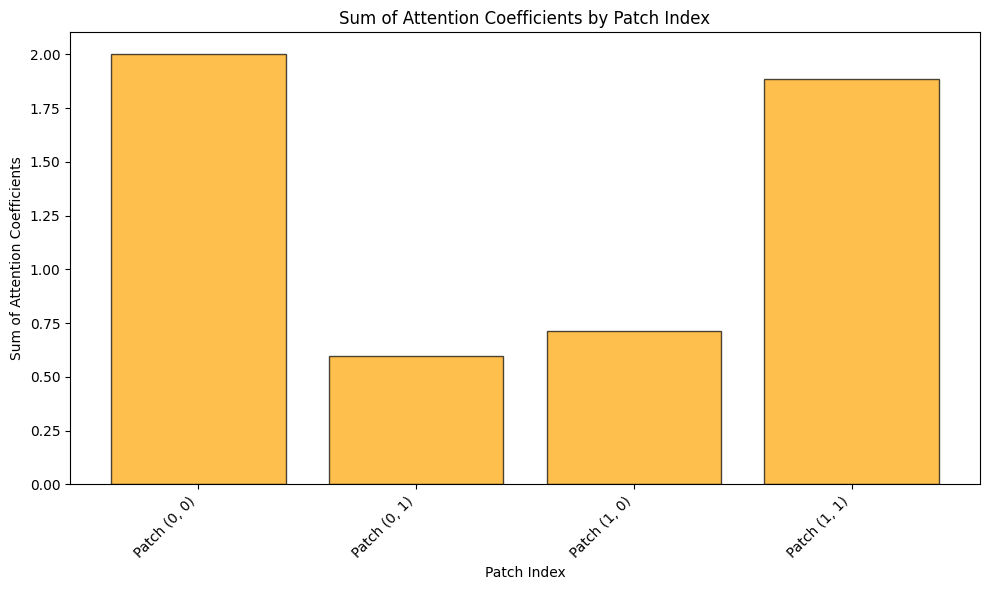

 54%|█████▍    | 19/35 [00:02<00:02,  6.87it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 4, 2, 4, 2, 6, 2, 2, 0, 6, 3, 3, 1, 5, 2, 3, 0, 6,
        3, 5, 4, 1, 7, 3, 2, 2, 5, 4, 6, 1, 2, 4, 4, 3, 3, 5, 2, 2, 7, 4, 4, 8,
        0, 3, 5, 3, 3, 6, 4, 2, 4, 5, 7, 7, 3, 0, 2, 2, 6, 2, 4, 5, 3, 3, 0, 4,
        7, 0, 0, 5, 2, 3, 7, 6, 2, 8, 3, 3, 4, 0, 4, 5, 0, 3, 3, 4, 4, 2, 2, 4,
        6, 0, 7, 6, 2, 3, 0, 4, 3, 3, 5, 0, 3, 4, 2, 3, 0, 3, 2, 8, 5, 2, 2, 0,
        2, 7, 4, 3, 1, 2, 3, 8, 4, 8, 5, 3, 2, 4, 3, 0, 0, 4, 7, 4, 6, 4, 8, 3,
        4, 4, 3, 9, 6, 8, 4, 2, 7, 0, 3, 0, 2, 2, 2, 2, 3, 2, 5, 0, 0, 6, 1, 6,
        0, 0, 7, 4, 3, 5, 7, 3, 0, 0, 7, 4, 4, 0, 6, 1, 4, 4, 8, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 4, 0, 3, 2, 0, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 3, 2, 0, 3,
        4, 8, 2, 3, 4, 0, 2, 4, 2, 5, 3, 2, 6, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        4, 3, 3, 4, 8, 9, 9, 0, 4, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 4, 0, 7, 5, 2, 2, 0, 3, 2, 3, 6, 2, 4, 4, 2, 7, 3, 3, 9, 8, 2, 7, 3,
        2, 5, 2, 2, 5, 1, 3, 9, 5, 0, 3,

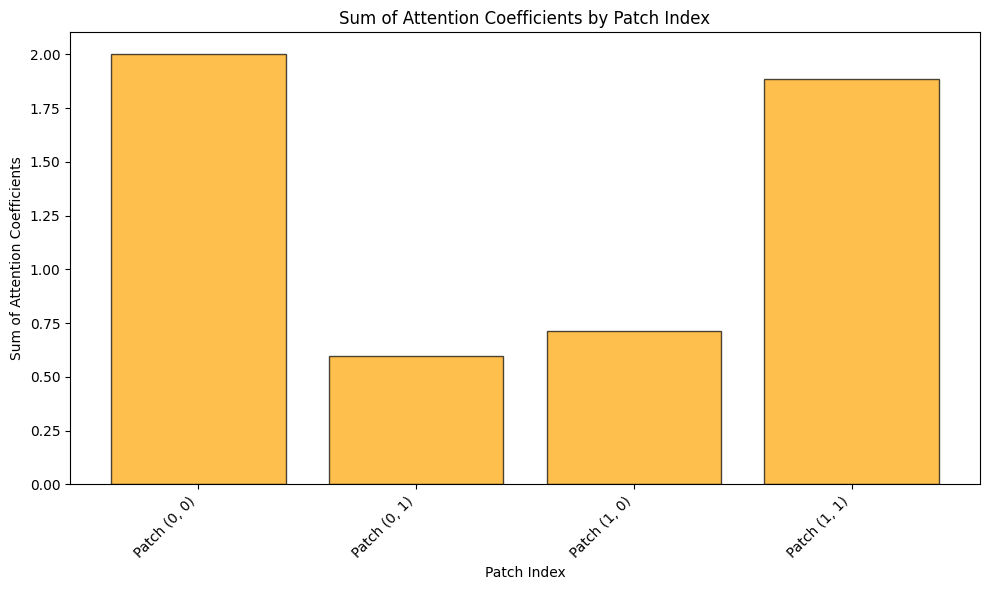

 57%|█████▋    | 20/35 [00:02<00:02,  6.73it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 4, 2, 4, 2, 6, 2, 2, 0, 6, 3, 3, 1, 5, 2, 3, 0, 6,
        7, 5, 4, 1, 7, 3, 2, 2, 5, 4, 6, 1, 2, 8, 4, 3, 3, 5, 2, 2, 7, 4, 4, 8,
        0, 3, 5, 3, 3, 6, 4, 2, 1, 5, 7, 7, 3, 0, 2, 2, 6, 2, 3, 5, 3, 3, 0, 4,
        7, 0, 0, 5, 2, 3, 7, 6, 2, 7, 3, 3, 0, 0, 4, 5, 0, 3, 3, 4, 4, 2, 2, 4,
        6, 0, 7, 6, 2, 3, 0, 4, 3, 3, 5, 0, 3, 4, 2, 3, 0, 3, 2, 8, 5, 2, 2, 0,
        2, 7, 4, 3, 1, 2, 3, 8, 4, 8, 5, 7, 2, 0, 3, 0, 0, 4, 7, 4, 6, 4, 8, 3,
        4, 2, 3, 9, 6, 8, 4, 2, 7, 0, 3, 0, 2, 2, 2, 2, 3, 2, 5, 0, 0, 6, 1, 6,
        0, 0, 7, 6, 3, 5, 7, 3, 0, 0, 7, 4, 4, 0, 7, 1, 4, 4, 8, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 4, 0, 3, 2, 0, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 3, 2, 1, 3,
        4, 8, 2, 3, 4, 0, 2, 4, 2, 5, 3, 2, 6, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        4, 3, 3, 4, 8, 9, 9, 0, 4, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 4, 0, 7, 5, 2, 2, 0, 3, 2, 3, 6, 2, 4, 4, 2, 7, 3, 3, 9, 8, 2, 7, 3,
        2, 5, 2, 2, 5, 1, 3, 9, 5, 0, 3,

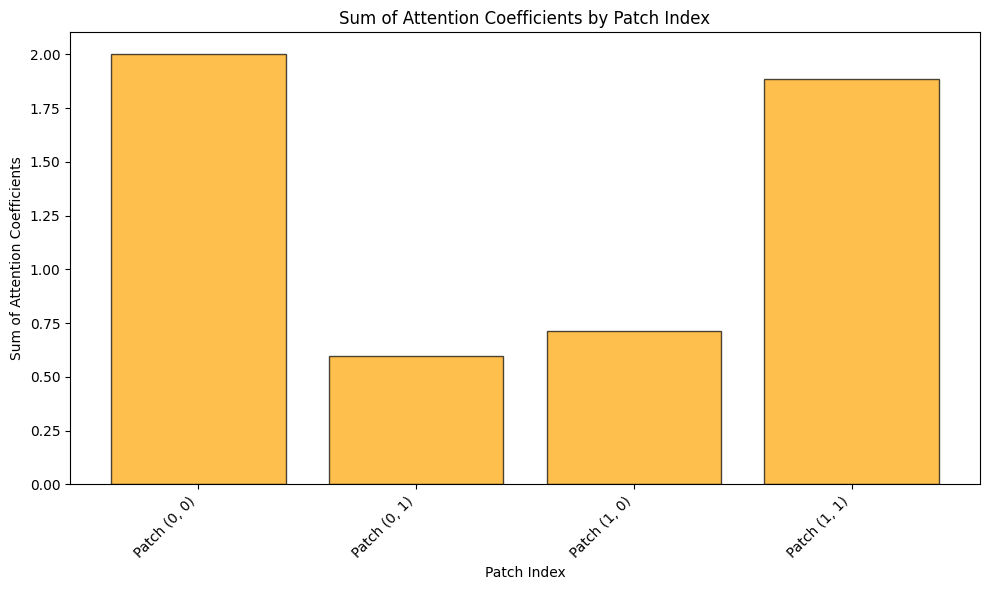

 60%|██████    | 21/35 [00:03<00:02,  6.74it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 7, 2, 4, 2, 6, 2, 2, 0, 6, 3, 3, 1, 5, 2, 3, 0, 6,
        7, 5, 4, 1, 7, 3, 2, 2, 3, 4, 6, 1, 2, 8, 4, 3, 3, 5, 2, 2, 7, 4, 8, 8,
        0, 3, 5, 3, 3, 6, 4, 2, 1, 7, 7, 7, 7, 0, 2, 2, 6, 2, 3, 1, 3, 3, 0, 4,
        7, 0, 0, 5, 2, 3, 7, 6, 2, 7, 3, 3, 0, 7, 4, 5, 0, 3, 3, 4, 4, 2, 2, 4,
        6, 0, 7, 6, 2, 3, 7, 4, 3, 3, 5, 0, 3, 4, 2, 7, 0, 3, 2, 1, 5, 2, 2, 0,
        2, 7, 4, 3, 1, 2, 3, 8, 4, 8, 5, 7, 2, 0, 3, 0, 0, 4, 7, 4, 6, 4, 1, 3,
        4, 2, 3, 9, 6, 8, 4, 2, 7, 0, 3, 0, 2, 2, 2, 2, 3, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 7, 3, 0, 0, 7, 4, 4, 0, 7, 1, 8, 4, 7, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 5, 0, 3, 2, 0, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 3, 7, 1, 3,
        4, 8, 2, 3, 4, 0, 2, 4, 2, 5, 3, 2, 2, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        4, 3, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 4, 0, 7, 5, 2, 2, 0, 3, 2, 3, 6, 2, 4, 4, 2, 7, 3, 3, 9, 8, 2, 7, 3,
        2, 5, 2, 2, 3, 1, 3, 9, 5, 0, 3,

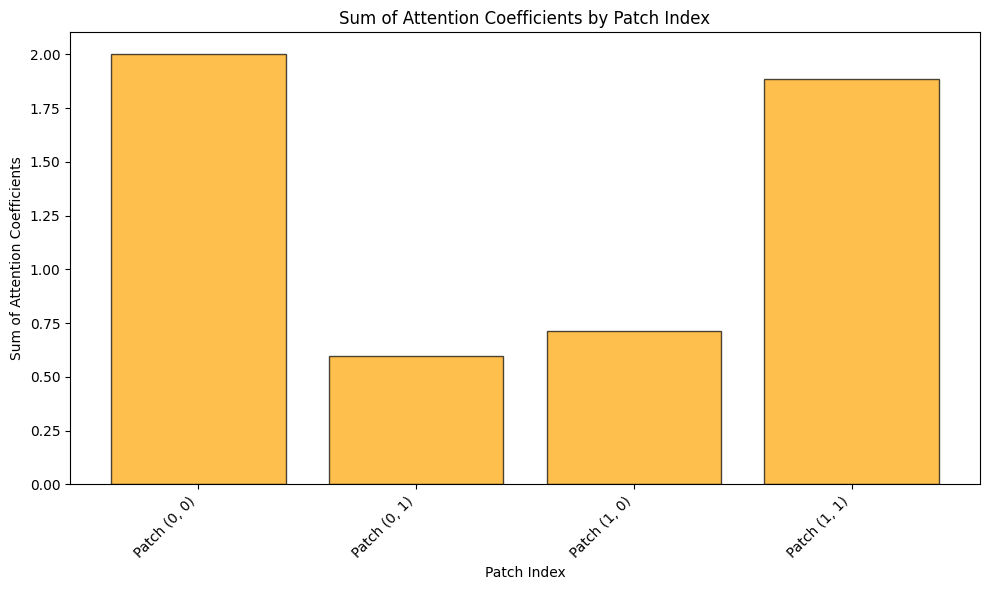

 63%|██████▎   | 22/35 [00:03<00:01,  6.77it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 7, 2, 4, 2, 6, 2, 2, 0, 1, 3, 3, 1, 7, 2, 3, 0, 6,
        7, 1, 4, 1, 7, 3, 2, 2, 3, 4, 6, 1, 2, 8, 4, 3, 3, 5, 2, 2, 7, 4, 8, 8,
        0, 3, 5, 3, 3, 6, 4, 2, 1, 7, 7, 7, 7, 0, 2, 2, 6, 2, 3, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 7, 3, 3, 0, 7, 4, 5, 0, 3, 3, 4, 4, 2, 5, 4,
        6, 0, 7, 6, 2, 3, 7, 4, 3, 3, 5, 0, 3, 4, 2, 7, 0, 3, 2, 1, 5, 2, 2, 0,
        2, 7, 4, 2, 1, 2, 7, 8, 4, 8, 5, 7, 2, 0, 3, 0, 0, 4, 7, 4, 6, 4, 1, 3,
        4, 2, 3, 9, 6, 8, 4, 2, 7, 0, 6, 0, 2, 2, 2, 2, 3, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 7, 3, 0, 0, 7, 4, 4, 0, 7, 1, 8, 4, 7, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 5, 0, 3, 2, 0, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 7, 7, 1, 3,
        4, 8, 2, 3, 4, 0, 2, 4, 2, 5, 3, 2, 6, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        4, 3, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 4, 0, 7, 5, 2, 2, 0, 1, 2, 3, 6, 2, 4, 4, 2, 7, 7, 3, 9, 8, 2, 7, 3,
        2, 5, 2, 2, 3, 1, 3, 9, 5, 0, 3,

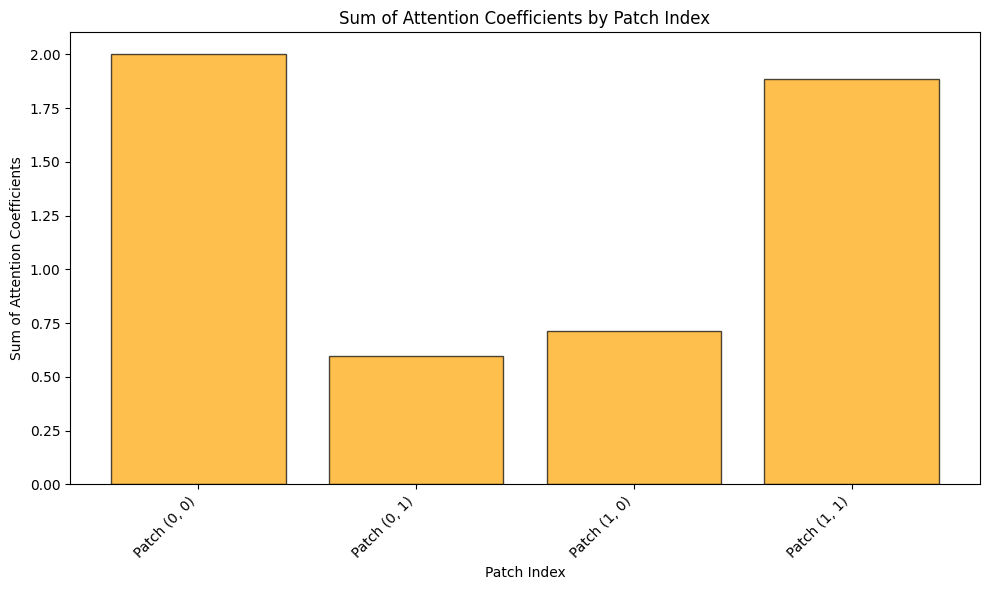

 66%|██████▌   | 23/35 [00:03<00:01,  6.74it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 7, 2, 4, 2, 6, 2, 2, 0, 1, 3, 7, 1, 7, 2, 3, 0, 6,
        7, 1, 4, 1, 7, 7, 2, 2, 6, 4, 6, 1, 2, 8, 4, 3, 3, 5, 2, 2, 7, 6, 8, 7,
        0, 3, 5, 3, 3, 6, 4, 2, 1, 7, 7, 7, 7, 0, 2, 2, 6, 2, 3, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 7, 3, 3, 0, 7, 4, 5, 0, 3, 3, 4, 8, 2, 5, 4,
        6, 0, 7, 6, 2, 3, 7, 4, 3, 3, 5, 0, 3, 4, 2, 7, 0, 2, 2, 1, 5, 2, 2, 0,
        2, 7, 4, 2, 1, 2, 7, 8, 4, 8, 5, 7, 2, 0, 3, 0, 1, 4, 7, 4, 6, 4, 1, 3,
        7, 2, 3, 9, 6, 8, 4, 2, 7, 0, 6, 0, 2, 2, 2, 2, 2, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 7, 3, 0, 0, 7, 4, 4, 0, 7, 1, 8, 4, 7, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 5, 0, 3, 2, 0, 4, 4, 1, 8, 1, 4, 2, 4, 3, 0, 7, 7, 1, 3,
        4, 8, 2, 3, 4, 0, 2, 4, 2, 5, 3, 2, 6, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        4, 3, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 5, 0, 7, 5, 2, 2, 0, 1, 2, 3, 6, 2, 4, 4, 2, 7, 7, 3, 9, 8, 2, 7, 3,
        2, 5, 2, 2, 3, 1, 3, 9, 5, 0, 3,

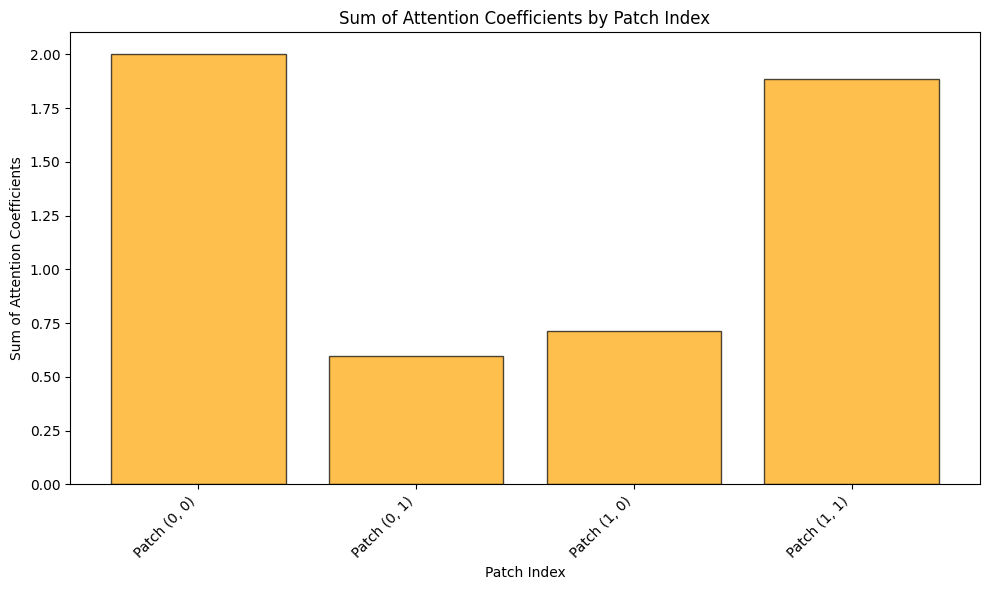

 69%|██████▊   | 24/35 [00:03<00:01,  6.76it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 7, 2, 4, 2, 6, 2, 2, 0, 1, 3, 7, 1, 7, 2, 3, 0, 6,
        7, 1, 4, 1, 7, 7, 2, 2, 6, 4, 6, 1, 7, 8, 4, 0, 3, 5, 2, 2, 7, 6, 1, 7,
        0, 3, 5, 3, 3, 6, 4, 2, 1, 7, 7, 7, 7, 0, 2, 2, 6, 2, 3, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 7, 3, 3, 0, 7, 4, 5, 0, 0, 3, 4, 8, 2, 5, 4,
        6, 0, 7, 6, 2, 3, 7, 0, 8, 3, 5, 0, 3, 4, 2, 7, 0, 2, 2, 1, 5, 2, 2, 0,
        2, 7, 4, 2, 1, 2, 7, 8, 4, 8, 5, 7, 2, 0, 0, 0, 1, 4, 7, 4, 6, 4, 1, 3,
        7, 6, 3, 9, 6, 8, 4, 2, 7, 0, 6, 0, 2, 2, 2, 2, 2, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 7, 5, 0, 0, 7, 4, 2, 0, 7, 1, 8, 4, 7, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 5, 0, 3, 2, 0, 4, 1, 1, 8, 1, 4, 2, 4, 3, 0, 7, 7, 1, 3,
        7, 8, 2, 8, 4, 0, 2, 4, 2, 5, 3, 2, 6, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        4, 3, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 5, 0, 7, 5, 2, 2, 0, 1, 2, 3, 6, 2, 4, 4, 2, 7, 7, 3, 9, 8, 2, 7, 3,
        2, 5, 2, 2, 3, 1, 3, 9, 5, 0, 3,

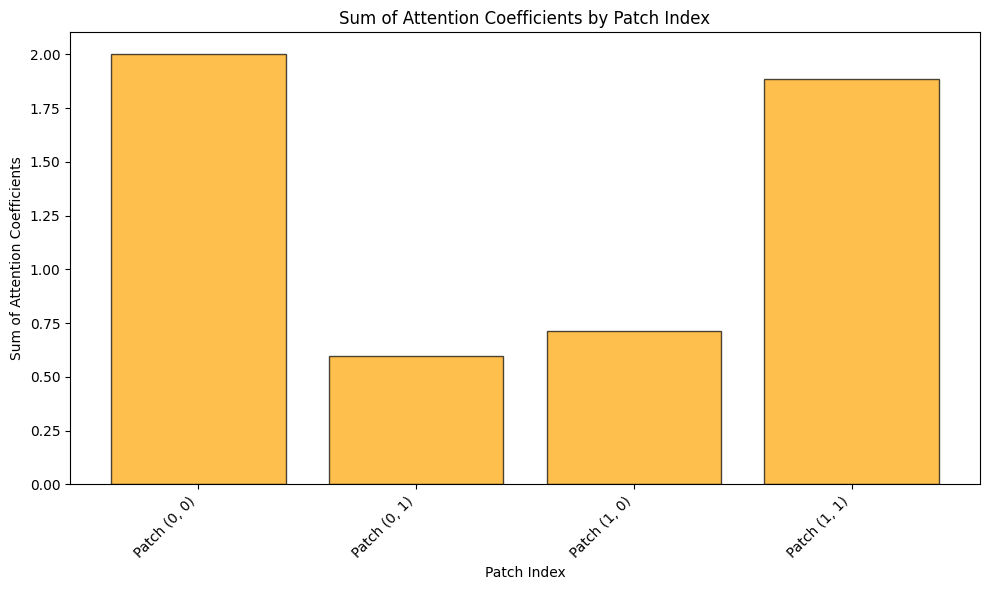

 71%|███████▏  | 25/35 [00:03<00:01,  6.78it/s]

tensor([0, 8, 2, 4, 3, 3, 2, 7, 2, 4, 2, 6, 2, 2, 0, 1, 3, 7, 1, 7, 2, 3, 0, 1,
        7, 1, 4, 1, 7, 7, 2, 2, 6, 4, 6, 1, 7, 1, 4, 0, 3, 5, 2, 2, 7, 6, 1, 7,
        0, 3, 5, 3, 3, 6, 4, 9, 1, 7, 7, 7, 7, 0, 2, 7, 6, 2, 3, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 7, 3, 3, 0, 7, 4, 5, 0, 0, 3, 4, 8, 2, 5, 4,
        6, 0, 7, 6, 2, 3, 7, 0, 8, 3, 5, 0, 3, 4, 2, 7, 0, 1, 2, 1, 5, 2, 2, 0,
        2, 7, 4, 1, 1, 2, 7, 8, 4, 8, 5, 7, 2, 0, 0, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        7, 6, 3, 9, 6, 8, 7, 2, 7, 0, 6, 0, 2, 2, 2, 2, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 7, 5, 0, 0, 7, 4, 2, 0, 7, 1, 8, 4, 1, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 5, 0, 3, 2, 1, 4, 1, 1, 8, 1, 4, 2, 4, 3, 0, 7, 7, 1, 3,
        7, 8, 2, 8, 4, 0, 2, 4, 2, 5, 3, 2, 6, 0, 2, 4, 2, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 2, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 5, 0, 7, 5, 2, 2, 0, 1, 2, 8, 6, 2, 4, 4, 2, 7, 7, 3, 9, 8, 2, 7, 3,
        2, 5, 2, 2, 3, 1, 3, 9, 5, 0, 3,

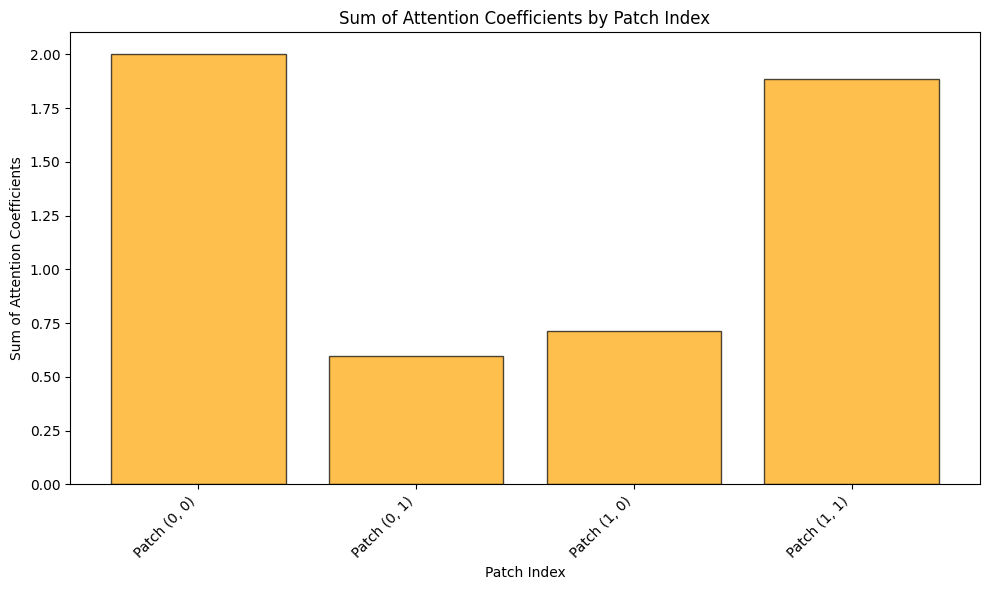

 74%|███████▍  | 26/35 [00:03<00:01,  6.79it/s]

tensor([0, 8, 2, 4, 5, 3, 2, 7, 2, 4, 2, 6, 2, 2, 0, 1, 3, 7, 1, 7, 2, 3, 0, 1,
        7, 1, 4, 1, 7, 7, 2, 2, 6, 4, 6, 1, 1, 1, 4, 0, 3, 5, 2, 2, 7, 6, 1, 7,
        0, 3, 5, 3, 3, 6, 6, 9, 1, 7, 7, 7, 7, 0, 2, 7, 6, 2, 3, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 7, 3, 3, 0, 7, 4, 5, 0, 0, 3, 4, 8, 2, 5, 4,
        6, 0, 7, 6, 2, 3, 7, 0, 8, 3, 5, 0, 3, 4, 2, 7, 0, 1, 2, 1, 5, 2, 2, 0,
        2, 7, 4, 1, 1, 1, 7, 8, 4, 8, 5, 7, 1, 0, 0, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        7, 6, 3, 9, 6, 8, 7, 2, 7, 0, 6, 0, 2, 2, 2, 7, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 7, 5, 0, 0, 7, 4, 1, 0, 7, 1, 8, 1, 1, 6, 6, 7, 2, 2,
        3, 6, 4, 0, 2, 5, 0, 3, 1, 1, 4, 1, 1, 8, 1, 4, 2, 4, 3, 0, 7, 7, 1, 3,
        7, 8, 2, 8, 4, 0, 2, 4, 2, 5, 6, 2, 6, 0, 2, 4, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 5, 0, 7, 5, 1, 2, 0, 1, 6, 8, 6, 2, 4, 4, 2, 7, 7, 3, 9, 8, 1, 7, 3,
        2, 5, 2, 2, 3, 1, 3, 9, 5, 0, 3,

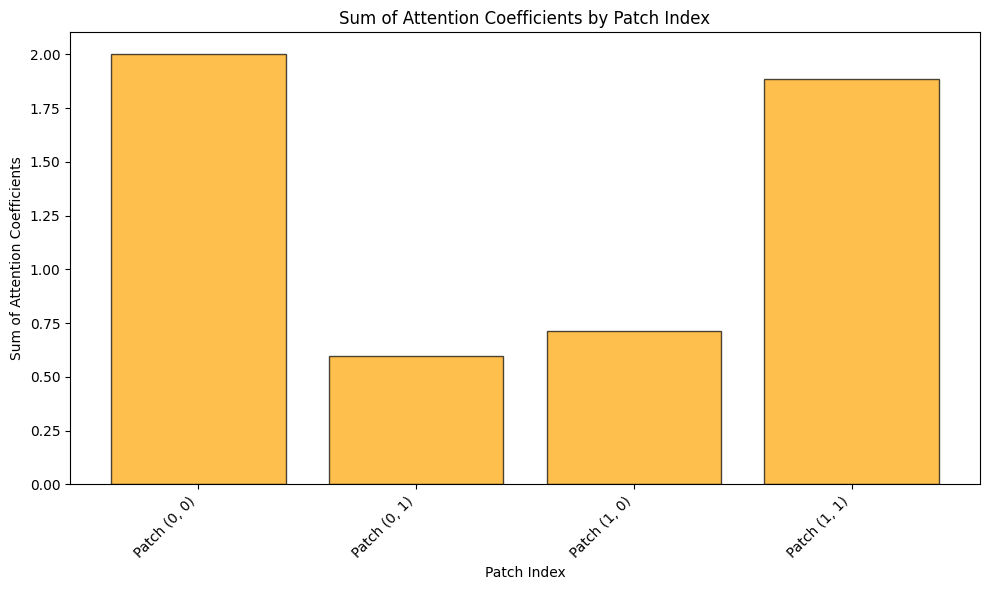

 77%|███████▋  | 27/35 [00:04<00:01,  6.81it/s]

tensor([0, 8, 2, 4, 5, 3, 2, 7, 6, 4, 1, 6, 2, 2, 0, 1, 3, 7, 1, 7, 2, 3, 0, 1,
        7, 1, 4, 1, 7, 3, 2, 2, 6, 4, 6, 1, 1, 1, 4, 0, 3, 8, 2, 2, 7, 6, 1, 8,
        0, 1, 5, 3, 3, 6, 8, 9, 1, 7, 7, 7, 7, 0, 2, 7, 6, 2, 3, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 7, 3, 3, 0, 0, 4, 5, 0, 0, 3, 4, 8, 2, 5, 4,
        1, 0, 7, 6, 2, 3, 1, 0, 8, 3, 5, 0, 0, 1, 2, 7, 0, 1, 2, 1, 5, 2, 2, 0,
        2, 7, 4, 1, 1, 1, 7, 5, 4, 8, 5, 7, 1, 0, 1, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        7, 6, 3, 9, 6, 8, 7, 2, 7, 0, 6, 9, 6, 2, 2, 1, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 7, 5, 0, 0, 7, 4, 1, 0, 7, 1, 8, 1, 1, 6, 6, 7, 6, 2,
        3, 6, 4, 0, 2, 5, 0, 3, 1, 1, 4, 1, 1, 8, 1, 4, 2, 4, 3, 0, 7, 7, 1, 3,
        7, 8, 2, 8, 4, 0, 2, 4, 2, 5, 6, 2, 6, 0, 2, 4, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 8, 4, 7, 1, 1, 6, 3, 2, 5,
        0, 5, 0, 7, 5, 1, 2, 0, 1, 6, 8, 6, 2, 8, 4, 2, 7, 7, 3, 9, 8, 1, 7, 3,
        2, 5, 2, 2, 3, 1, 3, 9, 5, 0, 3,

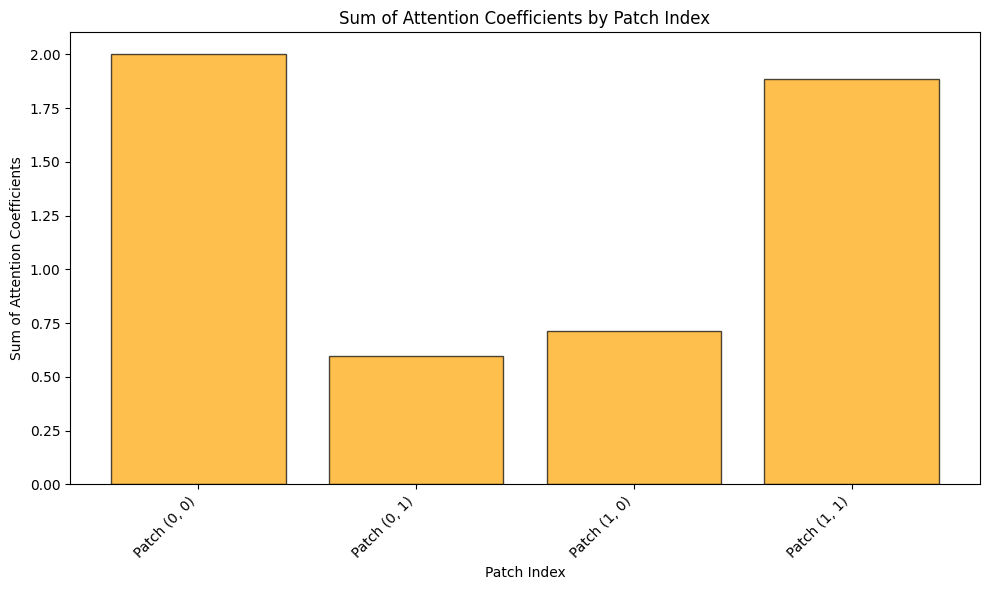

 80%|████████  | 28/35 [00:04<00:01,  6.82it/s]

tensor([0, 8, 2, 4, 5, 3, 1, 7, 6, 4, 1, 6, 2, 1, 0, 1, 3, 7, 1, 7, 2, 3, 0, 1,
        7, 1, 4, 1, 7, 3, 2, 2, 6, 4, 6, 1, 1, 1, 4, 0, 3, 8, 2, 2, 7, 6, 1, 8,
        0, 1, 5, 3, 3, 6, 8, 9, 1, 7, 7, 7, 7, 0, 2, 7, 6, 1, 3, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 7, 3, 3, 0, 9, 4, 5, 0, 0, 3, 4, 8, 2, 5, 4,
        1, 0, 7, 6, 2, 3, 1, 0, 8, 3, 5, 0, 0, 1, 2, 7, 0, 1, 2, 1, 5, 2, 2, 0,
        2, 7, 4, 1, 1, 1, 7, 5, 4, 8, 5, 7, 1, 0, 1, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        6, 6, 3, 9, 6, 8, 7, 2, 7, 0, 6, 9, 6, 2, 2, 1, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 7, 5, 0, 0, 7, 4, 1, 0, 7, 1, 8, 1, 1, 6, 6, 6, 6, 2,
        3, 6, 4, 0, 2, 5, 0, 8, 1, 1, 4, 1, 1, 8, 1, 4, 2, 4, 3, 0, 7, 7, 1, 3,
        7, 8, 2, 8, 4, 0, 2, 4, 2, 5, 6, 2, 6, 0, 2, 4, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 1, 4, 7, 1, 1, 6, 3, 1, 5,
        0, 5, 0, 7, 5, 1, 2, 0, 1, 6, 8, 6, 1, 8, 4, 2, 7, 7, 1, 9, 8, 1, 7, 3,
        2, 5, 2, 6, 3, 1, 3, 9, 5, 0, 3,

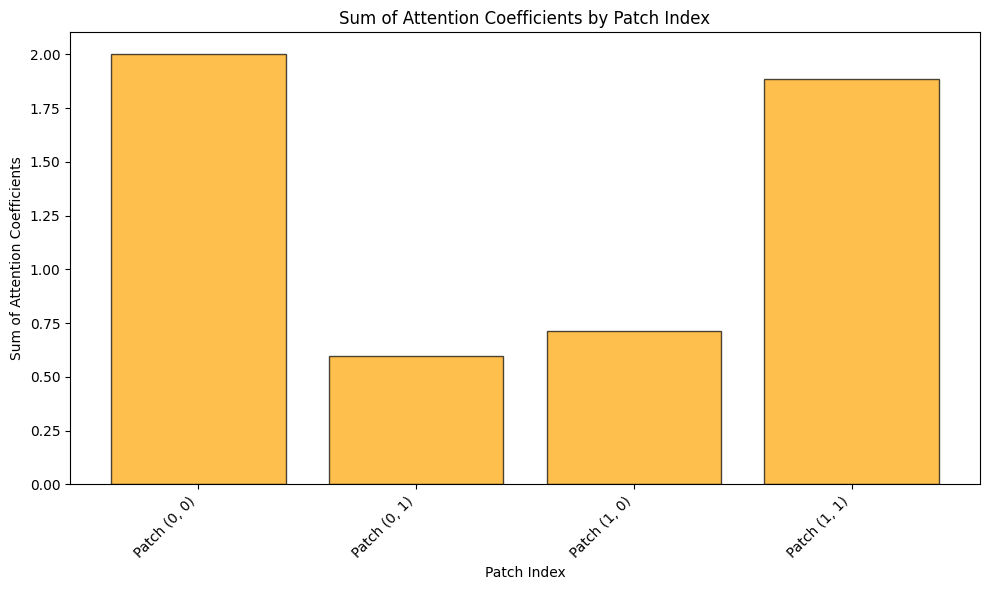

 83%|████████▎ | 29/35 [00:04<00:00,  6.83it/s]

tensor([0, 8, 2, 4, 5, 3, 1, 7, 6, 4, 1, 6, 2, 1, 0, 1, 3, 8, 1, 7, 1, 3, 0, 1,
        7, 1, 4, 1, 7, 3, 2, 2, 6, 4, 6, 1, 1, 1, 4, 0, 3, 8, 2, 6, 7, 6, 1, 8,
        0, 1, 5, 3, 3, 6, 8, 9, 1, 7, 7, 7, 7, 0, 2, 7, 6, 1, 3, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 7, 3, 3, 0, 9, 4, 5, 0, 0, 3, 8, 8, 2, 5, 4,
        1, 0, 7, 6, 2, 3, 1, 0, 8, 3, 5, 0, 0, 1, 2, 7, 0, 1, 1, 1, 5, 1, 2, 0,
        2, 7, 4, 1, 1, 1, 7, 5, 4, 8, 5, 8, 1, 0, 1, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        6, 6, 3, 9, 6, 8, 5, 2, 7, 0, 6, 9, 6, 2, 2, 1, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 7, 5, 0, 0, 7, 4, 1, 0, 7, 1, 8, 1, 1, 6, 6, 1, 6, 2,
        3, 6, 4, 0, 6, 5, 0, 8, 1, 1, 4, 1, 1, 8, 1, 4, 2, 4, 3, 0, 7, 7, 1, 3,
        7, 8, 2, 8, 4, 0, 2, 4, 2, 5, 6, 2, 6, 0, 2, 1, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 1, 4, 7, 1, 1, 6, 3, 1, 5,
        0, 5, 0, 7, 5, 1, 2, 0, 1, 6, 8, 6, 1, 8, 4, 2, 7, 7, 1, 9, 8, 1, 7, 3,
        2, 5, 2, 6, 3, 1, 3, 9, 5, 0, 3,

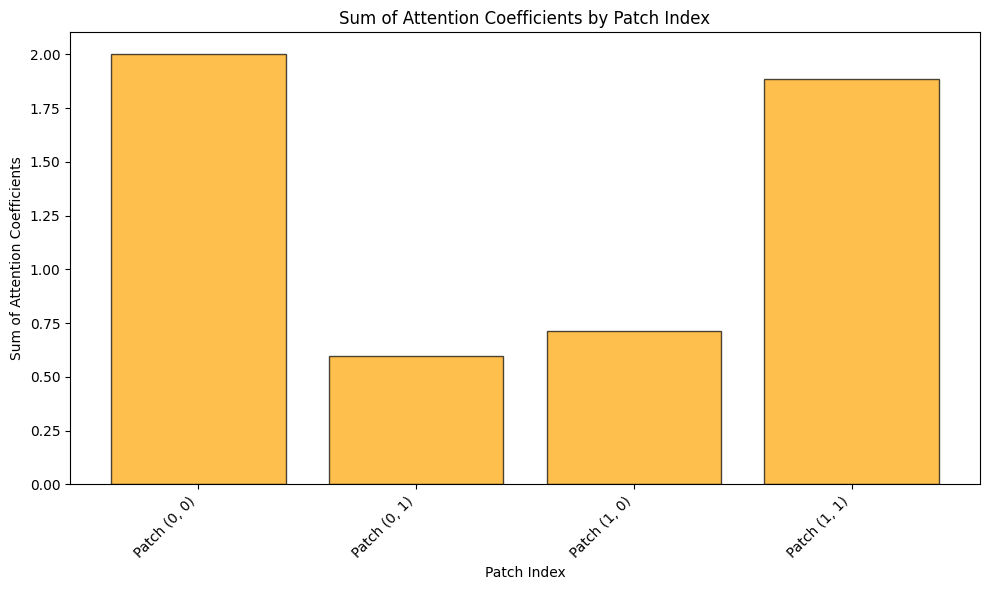

 86%|████████▌ | 30/35 [00:04<00:00,  6.83it/s]

tensor([0, 8, 2, 4, 5, 3, 1, 7, 6, 4, 1, 6, 2, 1, 0, 1, 3, 8, 1, 7, 1, 3, 0, 1,
        3, 1, 4, 1, 7, 3, 2, 2, 6, 4, 6, 1, 1, 1, 4, 0, 3, 8, 2, 1, 7, 1, 1, 8,
        0, 1, 5, 3, 3, 6, 8, 9, 1, 7, 7, 7, 7, 0, 2, 7, 6, 1, 3, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 7, 3, 3, 0, 9, 4, 5, 0, 1, 8, 8, 8, 4, 5, 4,
        1, 0, 7, 5, 2, 3, 1, 0, 8, 3, 5, 1, 0, 1, 2, 6, 0, 1, 1, 1, 5, 1, 2, 0,
        2, 7, 4, 1, 1, 1, 7, 5, 4, 8, 5, 8, 1, 0, 1, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        6, 6, 3, 9, 6, 8, 5, 2, 7, 0, 6, 9, 6, 2, 2, 1, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 1, 5, 0, 0, 7, 4, 1, 0, 7, 1, 8, 1, 1, 6, 6, 1, 6, 2,
        3, 6, 4, 0, 6, 5, 0, 8, 1, 1, 4, 1, 1, 8, 1, 4, 2, 4, 3, 0, 7, 7, 1, 3,
        7, 8, 2, 8, 4, 0, 1, 4, 2, 5, 6, 2, 6, 0, 2, 1, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 1, 4, 7, 1, 1, 6, 3, 1, 5,
        0, 5, 0, 7, 5, 1, 2, 0, 1, 6, 8, 6, 1, 8, 4, 2, 7, 7, 1, 9, 8, 1, 7, 3,
        1, 5, 2, 1, 3, 1, 3, 9, 5, 0, 3,

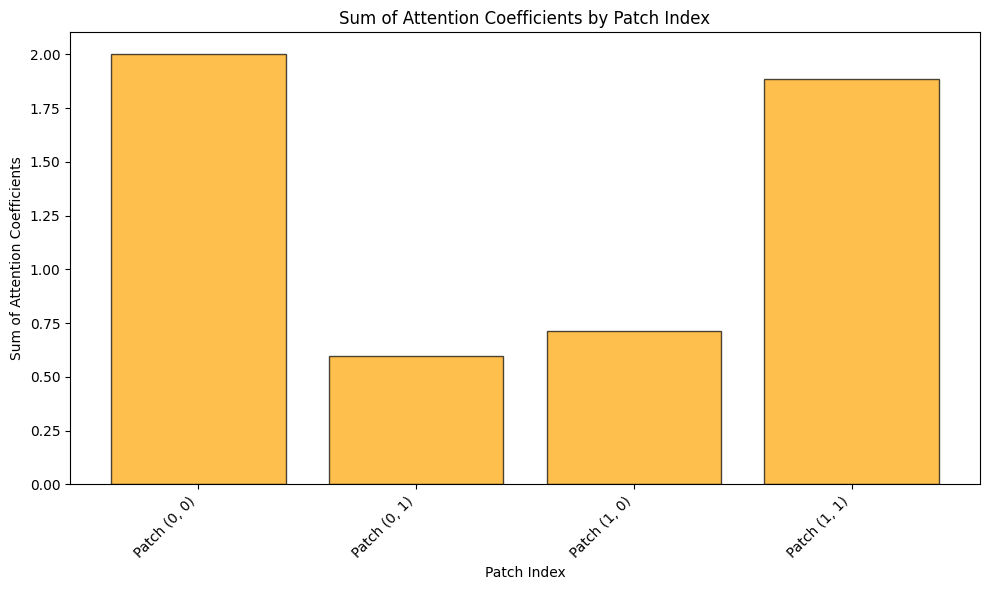

 89%|████████▊ | 31/35 [00:04<00:00,  6.81it/s]

tensor([0, 8, 2, 4, 5, 3, 1, 7, 6, 4, 1, 6, 2, 1, 0, 1, 3, 8, 1, 7, 1, 3, 0, 1,
        3, 1, 4, 1, 7, 3, 2, 2, 6, 4, 6, 1, 1, 1, 4, 7, 3, 8, 2, 1, 7, 1, 1, 8,
        0, 1, 5, 3, 3, 1, 8, 9, 1, 7, 7, 7, 7, 0, 2, 7, 6, 1, 9, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 8, 3, 3, 0, 9, 4, 5, 0, 1, 8, 8, 8, 5, 5, 4,
        1, 0, 7, 5, 2, 3, 1, 0, 8, 3, 5, 1, 0, 1, 2, 6, 0, 1, 1, 1, 5, 1, 2, 0,
        2, 7, 4, 1, 1, 1, 7, 5, 4, 8, 5, 8, 1, 0, 1, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        6, 6, 3, 9, 6, 8, 5, 2, 7, 0, 6, 9, 6, 2, 2, 1, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 1, 5, 0, 0, 7, 4, 1, 0, 6, 1, 8, 1, 1, 6, 6, 1, 6, 2,
        3, 6, 4, 0, 6, 5, 0, 8, 1, 1, 4, 1, 1, 8, 1, 4, 2, 4, 3, 0, 6, 7, 1, 3,
        7, 8, 2, 8, 4, 0, 1, 4, 2, 5, 6, 2, 6, 0, 2, 1, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 1, 4, 7, 1, 1, 6, 5, 1, 5,
        0, 5, 0, 1, 5, 1, 2, 0, 1, 6, 8, 6, 1, 8, 4, 2, 7, 7, 1, 9, 8, 1, 7, 3,
        1, 5, 2, 1, 3, 1, 3, 9, 5, 0, 3,

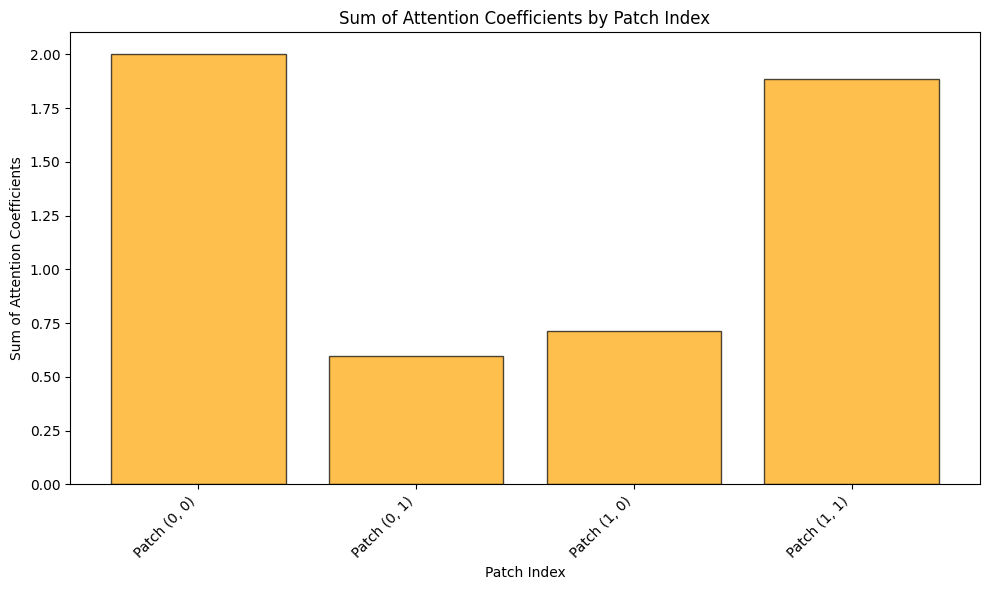

 91%|█████████▏| 32/35 [00:04<00:00,  6.81it/s]

tensor([0, 8, 2, 4, 5, 3, 1, 7, 6, 4, 1, 1, 2, 1, 0, 1, 3, 8, 1, 5, 1, 3, 0, 1,
        3, 1, 4, 1, 7, 3, 9, 2, 6, 4, 6, 1, 1, 1, 4, 7, 3, 8, 2, 1, 7, 1, 1, 8,
        0, 1, 5, 3, 3, 1, 8, 9, 1, 7, 7, 7, 7, 0, 2, 7, 6, 1, 9, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 8, 3, 3, 0, 9, 4, 5, 0, 1, 8, 8, 8, 5, 5, 4,
        1, 0, 7, 5, 2, 1, 9, 0, 8, 3, 5, 1, 0, 1, 2, 6, 0, 1, 1, 1, 5, 1, 2, 0,
        2, 7, 4, 1, 1, 1, 7, 5, 4, 8, 5, 8, 9, 0, 1, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        6, 6, 3, 9, 6, 8, 5, 5, 7, 0, 6, 9, 6, 2, 2, 1, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 1, 5, 0, 0, 7, 4, 1, 0, 6, 1, 8, 1, 1, 6, 6, 1, 6, 1,
        3, 6, 4, 0, 6, 5, 0, 8, 1, 1, 4, 1, 1, 8, 1, 4, 2, 4, 9, 0, 6, 7, 1, 3,
        7, 8, 1, 8, 4, 0, 1, 4, 5, 5, 6, 1, 6, 0, 2, 1, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 1, 4, 9, 1, 1, 6, 5, 1, 5,
        0, 5, 0, 1, 5, 1, 2, 0, 1, 6, 8, 6, 1, 8, 4, 6, 7, 7, 1, 9, 8, 1, 7, 3,
        1, 5, 6, 1, 3, 1, 3, 9, 5, 0, 3,

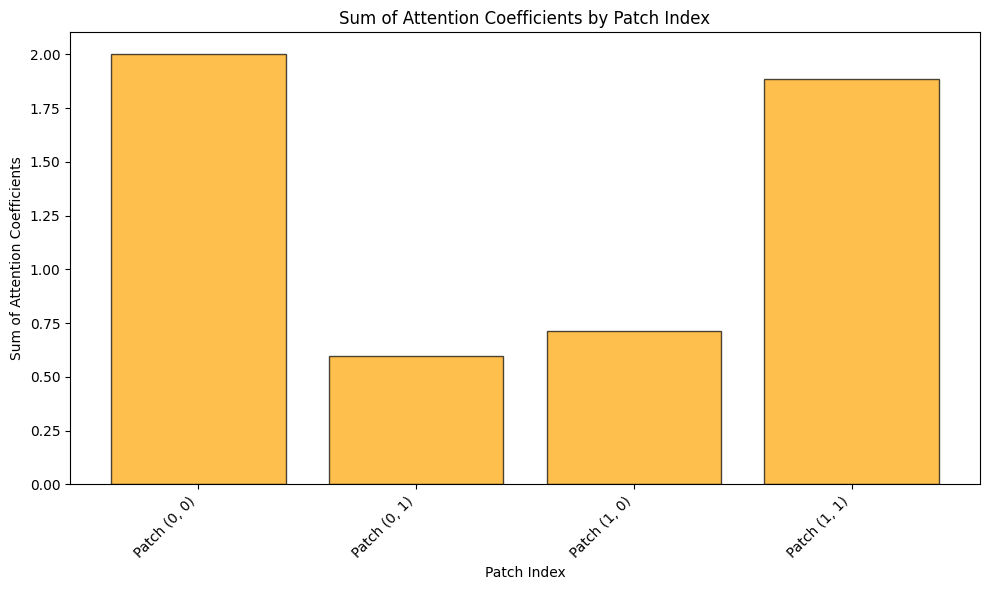

 94%|█████████▍| 33/35 [00:04<00:00,  6.84it/s]

tensor([0, 8, 2, 4, 5, 3, 1, 7, 6, 4, 1, 1, 2, 1, 0, 1, 3, 8, 1, 5, 1, 3, 0, 1,
        3, 1, 4, 1, 7, 3, 9, 2, 6, 4, 5, 1, 1, 1, 4, 5, 3, 8, 2, 1, 7, 1, 1, 8,
        0, 1, 5, 3, 3, 1, 8, 9, 1, 7, 7, 7, 7, 0, 2, 7, 6, 1, 9, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 8, 5, 3, 0, 9, 4, 5, 0, 1, 8, 8, 8, 5, 5, 4,
        1, 0, 7, 5, 2, 1, 9, 0, 8, 3, 5, 1, 0, 1, 2, 6, 0, 1, 1, 1, 5, 1, 2, 0,
        2, 7, 4, 1, 1, 1, 7, 5, 4, 8, 5, 8, 9, 0, 1, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        6, 6, 3, 9, 6, 8, 5, 5, 7, 0, 6, 9, 6, 2, 2, 1, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 7, 6, 3, 5, 1, 5, 0, 0, 7, 4, 1, 0, 6, 1, 8, 1, 1, 6, 6, 1, 6, 1,
        3, 6, 4, 0, 6, 5, 0, 1, 1, 9, 4, 1, 1, 8, 1, 4, 2, 4, 9, 0, 6, 7, 1, 3,
        7, 8, 1, 8, 4, 0, 1, 4, 5, 5, 6, 1, 6, 0, 2, 1, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 1, 4, 9, 1, 1, 6, 5, 1, 5,
        0, 5, 0, 1, 5, 1, 2, 0, 1, 6, 8, 6, 1, 8, 4, 6, 7, 7, 1, 9, 8, 1, 7, 3,
        1, 5, 6, 1, 3, 1, 3, 9, 5, 0, 3,

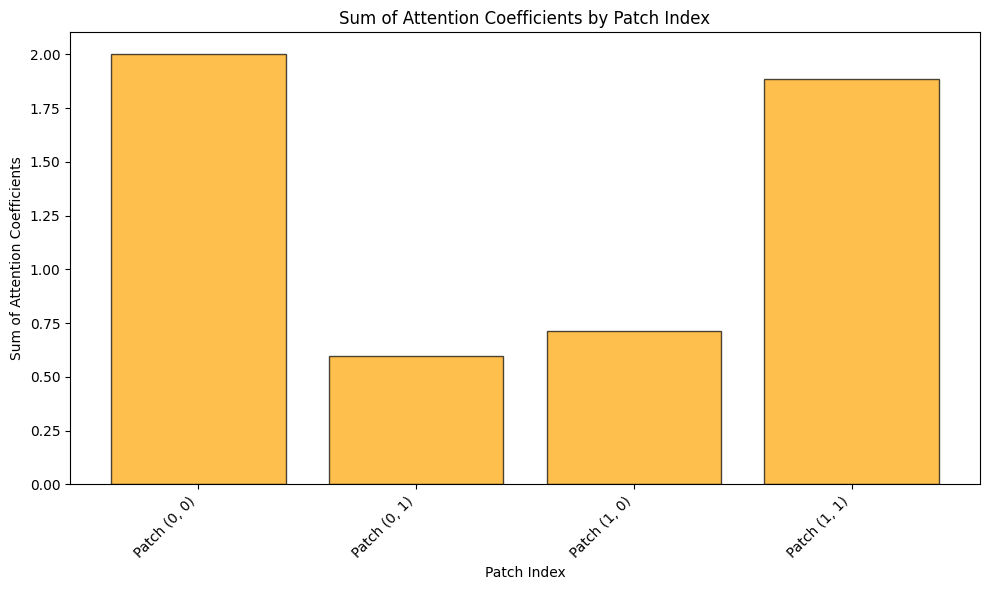

 97%|█████████▋| 34/35 [00:05<00:00,  6.79it/s]

tensor([0, 8, 2, 4, 5, 1, 1, 4, 6, 4, 1, 1, 2, 1, 0, 1, 3, 8, 1, 5, 1, 3, 0, 1,
        3, 1, 9, 1, 6, 3, 9, 2, 6, 4, 5, 1, 8, 1, 4, 5, 3, 8, 2, 1, 7, 1, 1, 8,
        0, 1, 5, 3, 3, 1, 8, 9, 1, 7, 7, 1, 7, 0, 2, 2, 6, 1, 9, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 8, 5, 3, 0, 9, 4, 5, 0, 1, 8, 8, 8, 5, 5, 4,
        1, 0, 7, 5, 2, 1, 9, 0, 8, 3, 5, 9, 0, 1, 2, 6, 0, 1, 1, 1, 5, 1, 2, 0,
        2, 7, 4, 1, 1, 1, 3, 5, 4, 8, 5, 8, 9, 0, 1, 0, 1, 4, 7, 4, 6, 5, 1, 3,
        6, 6, 3, 9, 6, 8, 5, 5, 7, 0, 6, 9, 6, 2, 2, 1, 8, 2, 5, 0, 0, 6, 1, 1,
        0, 0, 8, 6, 3, 5, 1, 5, 0, 0, 7, 4, 1, 0, 6, 1, 8, 1, 1, 6, 6, 6, 6, 1,
        3, 6, 4, 0, 6, 5, 0, 1, 1, 9, 4, 1, 1, 8, 1, 4, 2, 4, 9, 0, 6, 7, 1, 3,
        7, 8, 2, 8, 4, 0, 1, 4, 5, 5, 6, 1, 6, 0, 2, 1, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 1, 4, 9, 1, 1, 6, 5, 1, 5,
        0, 5, 0, 1, 5, 1, 2, 0, 1, 6, 8, 6, 1, 8, 4, 6, 7, 5, 1, 9, 8, 1, 7, 3,
        1, 5, 6, 1, 3, 1, 3, 9, 5, 0, 3,

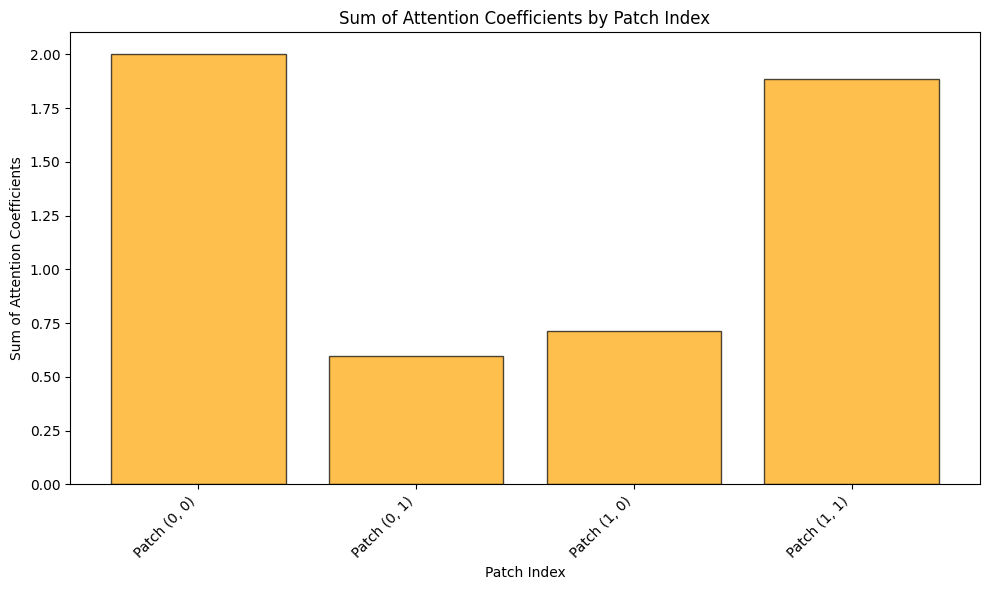

100%|██████████| 35/35 [00:05<00:00,  6.72it/s]

tensor([0, 8, 2, 4, 5, 1, 1, 4, 6, 4, 1, 1, 2, 1, 0, 1, 9, 8, 1, 5, 1, 3, 0, 1,
        3, 1, 9, 1, 6, 3, 9, 5, 6, 4, 5, 1, 8, 1, 4, 5, 3, 8, 8, 1, 7, 1, 1, 8,
        0, 1, 5, 3, 3, 1, 8, 9, 1, 7, 7, 1, 3, 0, 2, 3, 6, 1, 9, 1, 3, 0, 0, 4,
        7, 0, 0, 5, 2, 1, 7, 6, 2, 8, 5, 3, 0, 9, 4, 5, 0, 1, 8, 8, 8, 5, 5, 4,
        1, 0, 7, 5, 2, 1, 9, 0, 8, 3, 5, 9, 0, 1, 3, 6, 4, 1, 4, 1, 5, 1, 2, 0,
        2, 6, 4, 1, 1, 1, 3, 5, 4, 8, 5, 8, 9, 0, 1, 0, 1, 4, 6, 4, 6, 5, 1, 3,
        6, 6, 3, 9, 6, 8, 5, 5, 7, 0, 6, 9, 6, 2, 2, 1, 8, 2, 5, 0, 0, 6, 1, 1,
        9, 0, 8, 6, 3, 5, 1, 5, 0, 0, 7, 4, 1, 0, 6, 1, 8, 1, 1, 6, 6, 6, 6, 9,
        3, 6, 4, 0, 4, 5, 0, 1, 9, 9, 4, 1, 1, 8, 1, 4, 2, 4, 9, 0, 6, 2, 1, 3,
        7, 8, 2, 8, 4, 0, 1, 4, 5, 5, 6, 1, 6, 0, 2, 1, 5, 1, 4, 0, 7, 4, 3, 5,
        4, 1, 3, 4, 8, 9, 9, 0, 1, 8, 0, 0, 0, 1, 1, 1, 4, 9, 9, 1, 6, 5, 1, 5,
        0, 5, 0, 1, 5, 1, 2, 0, 1, 6, 8, 6, 1, 8, 4, 6, 7, 5, 1, 9, 8, 1, 5, 3,
        1, 5, 6, 1, 3, 1, 3, 9, 5, 0, 3,

In [36]:
for iepoch in tqdm(range(35)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    #for i in range(len(label)):
    #    if label[i]==1:
    #        label[i] = 0
    #    else:
    #        label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = multi_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()

shape torch.Size([80, 2, 4, 4])


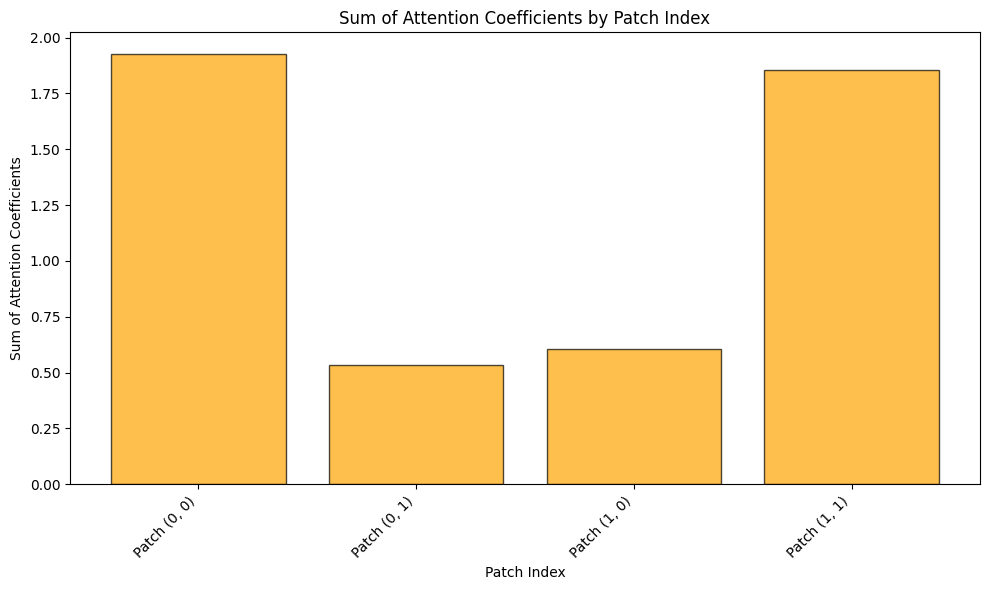

tensor([6, 4, 0, 1, 5, 2, 9, 6, 6, 8, 4, 9, 1, 3, 6, 7, 1, 1, 5, 5, 4, 1, 1, 3,
        1, 7, 0, 7, 6, 6, 1, 1, 1, 5, 6, 1, 4, 4, 2, 1, 0, 1, 2, 5, 6, 3, 8, 5,
        3, 7, 5, 9, 6, 5, 2, 7, 6, 8, 6, 1, 4, 0, 2, 8, 3, 6, 6, 1, 0, 4, 5, 6,
        6, 1, 7, 8, 0, 0, 0, 1])
tensor([6., 4., 0., 1., 4., 1., 7., 4., 5., 1., 4., 9., 7., 3., 6., 8., 2., 9.,
        6., 5., 7., 1., 5., 3., 2., 6., 0., 2., 2., 4., 2., 3., 8., 5., 1., 8.,
        6., 4., 7., 1., 0., 1., 2., 8., 1., 9., 8., 5., 3., 9., 5., 8., 1., 5.,
        9., 6., 6., 8., 6., 3., 4., 0., 3., 3., 3., 3., 7., 7., 0., 5., 5., 0.,
        1., 4., 9., 2., 6., 0., 0., 8.], dtype=torch.float64)

Accuracy: 0.4124999940395355

AUROC: 0.707355810347502

Precision (macro): 0.4348389355742297

Recall (macro): 0.38900793650793647

F1 Score (macro): 0.3972639397639398

AUPRC (macro): 0.3706681760145899



In [37]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, average_precision_score

# Convert test data to tensor
X_tensor = torch.tensor(X_test, dtype=torch.float32)
predictions = model(X_tensor)

# Convert y_train to tensor and change labels from 1 to 0, and 7 to 1
label=torch.tensor(y_test)
# label = torch.tensor(y_test, dtype=torch.long).clone()  # Ensure labels are LongTensor
        
# Compute loss
loss = criterion(predictions, label)

# Convert predictions and labels to numpy for sklearn metrics
preds_np = predictions.detach().numpy()  # Detach predictions from the graph and convert to numpy
labels_np = label.numpy()  # Convert labels to numpy

# Get predicted classes
predicted_classes = np.argmax(preds_np, axis=1)

# Calculate Accuracy
acc = multi_accuracy(predictions, label.float())

# Calculate AUROC for each class (one-vs-rest approach)
auroc = roc_auc_score(labels_np, preds_np, multi_class="ovr")

# Ensure labels_np is in class label form, not one-hot encoded
if labels_np.ndim > 1:
    labels_np = np.argmax(labels_np, axis=1)


# Calculate Precision, Recall, and F1 Score (macro average for multi-class)
precision, recall, f1, _ = precision_recall_fscore_support(labels_np, predicted_classes, average='macro')

# Calculate AUPRC (Area Under the Precision-Recall Curve) for each class
auprc = average_precision_score(labels_np, preds_np, average="macro")

# Print results
print(f'\nAccuracy: {acc}\n')
# print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')
print(f'Precision (macro): {precision}\n')
print(f'Recall (macro): {recall}\n')
print(f'F1 Score (macro): {f1}\n')
print(f'AUPRC (macro): {auprc}\n')